In [1]:
# remove the notebook root logger.\n",
import logging
logger = logging.getLogger()
logger.handlers = []


In [2]:
import pandas as pd

# Hierarchical Forecasting with PyAF

In this document , we give a use case of hierarchcial forecasting wioth PyAF. 

We study the problem of forecasting France wine exportation by wine type (Champagne , Bordeaux, etc), variant (red , white, sparkling etc) and destination country.

A dataset has been built based on French government opendata gratefully provided by the foreign trade ministry. This dataset is available here : https://github.com/antoinecarme/TimeSeriesData/tree/master/Stat_FR_CommExt. 

Please note that the original dataset is generic and contains export data for all foreign trade products to all possible countries with a significant level of detail (cars, crops, living animals , legal weapons , ...).



## Data Overview

The dataset is a collection of 2872 monthly time series overserved on a period ranging from 2012-01-01 to 2016-09-01.

Each time series has 50 rows (some data are missing in 2015 , under investigation) and represents the export of a given type of wine, a given variant to a unique contry.

The time series column name is built by concatenating the three above informations.

To simplify, we will reduce the number of countries to the 10 most signficant (`wine-friendly`) ones. This reduces the number of columns to 176 ;)

In [3]:
import datetime

filename = "https://raw.githubusercontent.com/antoinecarme/TimeSeriesData/master/Stat_FR_CommExt/merged/French_Wine_Export_in_Euros_Some_Countries.csv"

French_Wine_Export_in_Euros_DF = pd.read_csv(filename);

lDateColumn = 'Month';
French_Wine_Export_in_Euros_DF[lDateColumn] = French_Wine_Export_in_Euros_DF[lDateColumn].apply(lambda x : datetime.datetime.strptime(str(x), "%Y-%m-%d"))

French_Wine_Export_in_Euros_DF.head(5)


Month  ALSACE_BLANC_BE  ALSACE_BLANC_CA  ALSACE_BLANC_CH  \
0 2012-01-01          1131852           571940           257116   
1 2012-02-01           857289           585556           187917   
2 2012-03-01          1438501           834142           679281   
3 2012-04-01           986602           866221           523202   
4 2012-05-01           991668          1061702           611369   

   ALSACE_BLANC_CN  ALSACE_BLANC_DE  ALSACE_BLANC_GB  ALSACE_BLANC_HK  \
0           140013           357516           344274            51043   
1            89805           505896           424953            80220   
2           103577           583887           352675           102980   
3           203456           515903           403517            52773   
4            80327           767522           627232            78115   

   ALSACE_BLANC_JP  ALSACE_BLANC_NL  ...  RHÔNE_ROUGE_CA  RHÔNE_ROUGE_CH  \
0           329883           624695  ...          800628          650236   
1           239242           899144  ...          795356          680567   
2           394945          1093638  ...          873858         1318538   
3           260953           874217  ...         1004028          919493   
4           680323           994697  ...         2098300          632778   

   RHÔNE_ROUGE_CN  RHÔNE_ROUGE_DE  RHÔNE_ROUGE_GB  RHÔNE_ROUGE_HK  \
0         1127393          783952         1513332          335710   
1          188827          868576         1277664          197072   
2          856382          627236         2343448          132200   
3          460815          829432         1861188          128164   
4          239200          934532         2215922          202210   

   RHÔNE_ROUGE_JP  RHÔNE_ROUGE_NL  RHÔNE_ROUGE_OTHER  RHÔNE_ROUGE_US  
0          916965          314654              35418         1260510  
1          318522          516140              36604         2136484  
2          605914          410308              43197         3264810  
3          472522          290407              45396         2631466  
4          337894          284868              41469         2945175  

[5 rows x 177 columns]

In [4]:
French_Wine_Export_in_Euros_DF.describe()

ALSACE_BLANC_BE  ALSACE_BLANC_CA  ALSACE_BLANC_CH  ALSACE_BLANC_CN  \
count     5.000000e+01     5.000000e+01        50.000000        50.000000   
mean      1.189956e+06     8.037735e+05    428923.380000    119348.360000   
std       2.780384e+05     1.691507e+05    158179.648178     65116.609016   
min       5.477480e+05     3.514620e+05     88329.000000     19546.000000   
25%       1.004816e+06     6.791068e+05    316753.500000     82278.500000   
50%       1.161726e+06     8.070940e+05    445554.500000     98656.000000   
75%       1.323582e+06     8.880218e+05    542924.000000    161694.000000   
max       2.166585e+06     1.216720e+06    857207.000000    317661.000000   

       ALSACE_BLANC_DE  ALSACE_BLANC_GB  ALSACE_BLANC_HK  ALSACE_BLANC_JP  \
count     5.000000e+01        50.000000        50.000000        50.000000   
mean      6.173951e+05    414037.100000     88636.820000    361437.900000   
std       2.765474e+05    116398.158498     68347.582681    110140.042643   
min       3.131500e+05    168388.000000     31864.000000    192553.000000   
25%       4.801042e+05    333264.500000     52845.750000    293690.250000   
50%       5.449660e+05    401774.500000     76561.500000    335180.000000   
75%       6.549058e+05    515408.000000    102011.750000    417475.000000   
max       1.871515e+06    635447.000000    510151.000000    680323.000000   

       ALSACE_BLANC_NL  ALSACE_BLANC_OTHER  ...  RHÔNE_ROUGE_CA  \
count     5.000000e+01           50.000000  ...    5.000000e+01   
mean      8.035454e+05        38337.801569  ...    1.607702e+06   
std       2.732401e+05         6088.988573  ...    7.064099e+05   
min       3.085880e+05        18550.156250  ...    7.935600e+05   
25%       6.061862e+05        35457.417067  ...    1.047350e+06   
50%       7.884350e+05        38715.394123  ...    1.506712e+06   
75%       8.980862e+05        41900.001008  ...    1.936743e+06   
max       1.458234e+06        52823.280702  ...    3.946934e+06   

       RHÔNE_ROUGE_CH  RHÔNE_ROUGE_CN  RHÔNE_ROUGE_DE  RHÔNE_ROUGE_GB  \
count    5.000000e+01    5.000000e+01    5.000000e+01    5.000000e+01   
mean     8.523710e+05    7.498312e+05    1.072562e+06    2.876061e+06   
std      2.458533e+05    3.592653e+05    4.307817e+05    1.366642e+06   
min      3.992940e+05    1.888270e+05    5.558550e+05    1.277664e+06   
25%      6.819278e+05    5.089532e+05    7.219495e+05    2.025437e+06   
50%      8.120535e+05    7.065070e+05    9.246160e+05    2.519672e+06   
75%      1.023269e+06    9.285735e+05    1.207832e+06    3.018630e+06   
max      1.334550e+06    1.755449e+06    2.312776e+06    8.652432e+06   

       RHÔNE_ROUGE_HK  RHÔNE_ROUGE_JP  RHÔNE_ROUGE_NL  RHÔNE_ROUGE_OTHER  \
count       50.000000    5.000000e+01    5.000000e+01          50.000000   
mean    235678.640000    5.760031e+05    4.986103e+05       52907.080000   
std     140071.773582    2.398091e+05    1.720202e+05        9667.885799   
min      77550.000000    2.053840e+05    2.311020e+05       35238.000000   
25%     152307.750000    3.751060e+05    3.725818e+05       46721.000000   
50%     203395.000000    5.414685e+05    4.674045e+05       52305.000000   
75%     257873.500000    7.998980e+05    6.143272e+05       59756.250000   
max     879037.000000    1.076535e+06    1.063568e+06       71487.000000   

       RHÔNE_ROUGE_US  
count    5.000000e+01  
mean     2.912355e+06  
std      6.675896e+05  
min      1.260510e+06  
25%      2.500847e+06  
50%      2.896628e+06  
75%      3.380802e+06  
max      4.664273e+06  

[8 rows x 176 columns]

To give an example, the following plot compares the export of Champagne to Germany, Japan and UK:  

In [5]:
%matplotlib inline

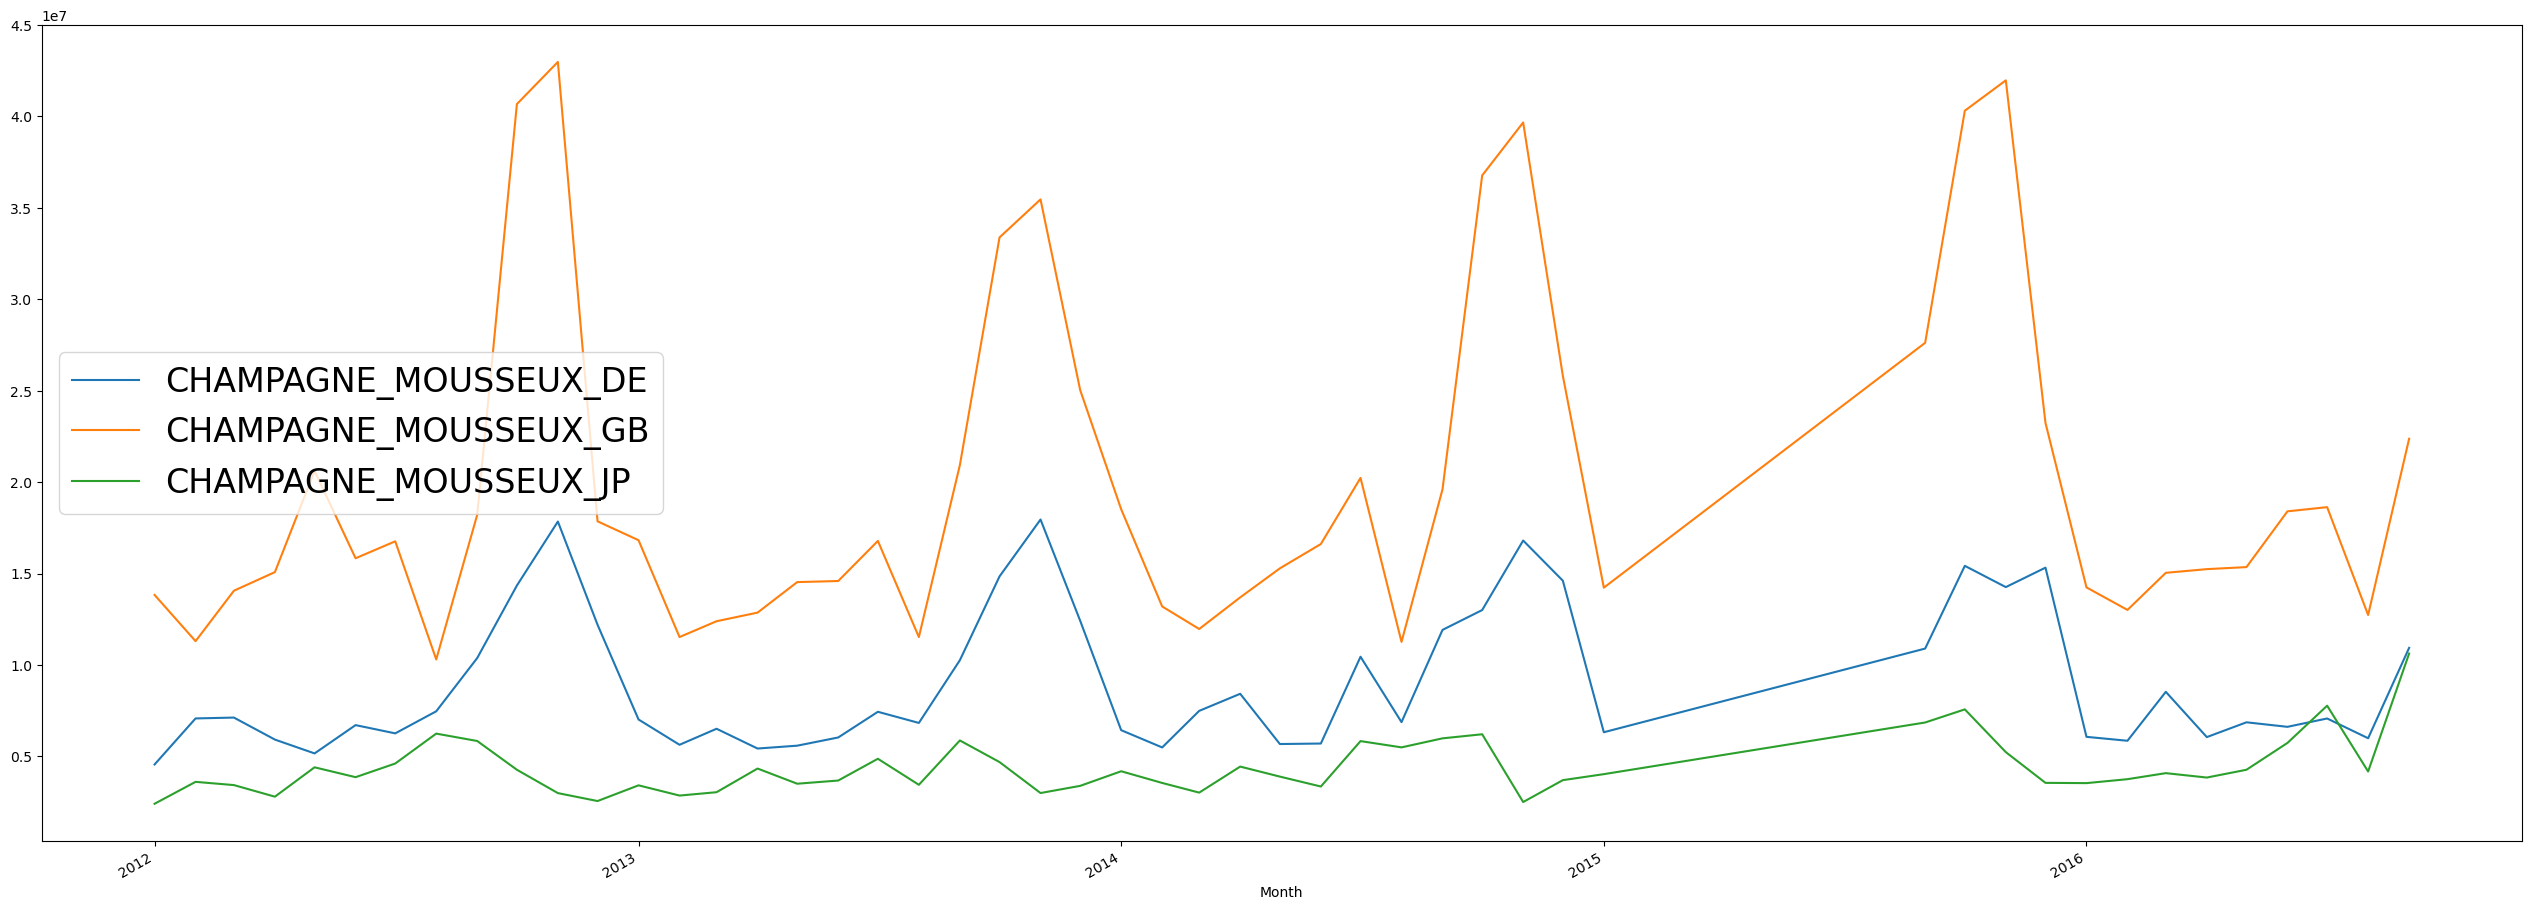

In [6]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    ['CHAMPAGNE_MOUSSEUX_DE', 'CHAMPAGNE_MOUSSEUX_GB' , 'CHAMPAGNE_MOUSSEUX_JP'],
                                   figsize=(32 , 12)).legend(loc='best', fontsize=24)

While the next one compares US consumption (in Euros) of red and white Bordeaux ;)

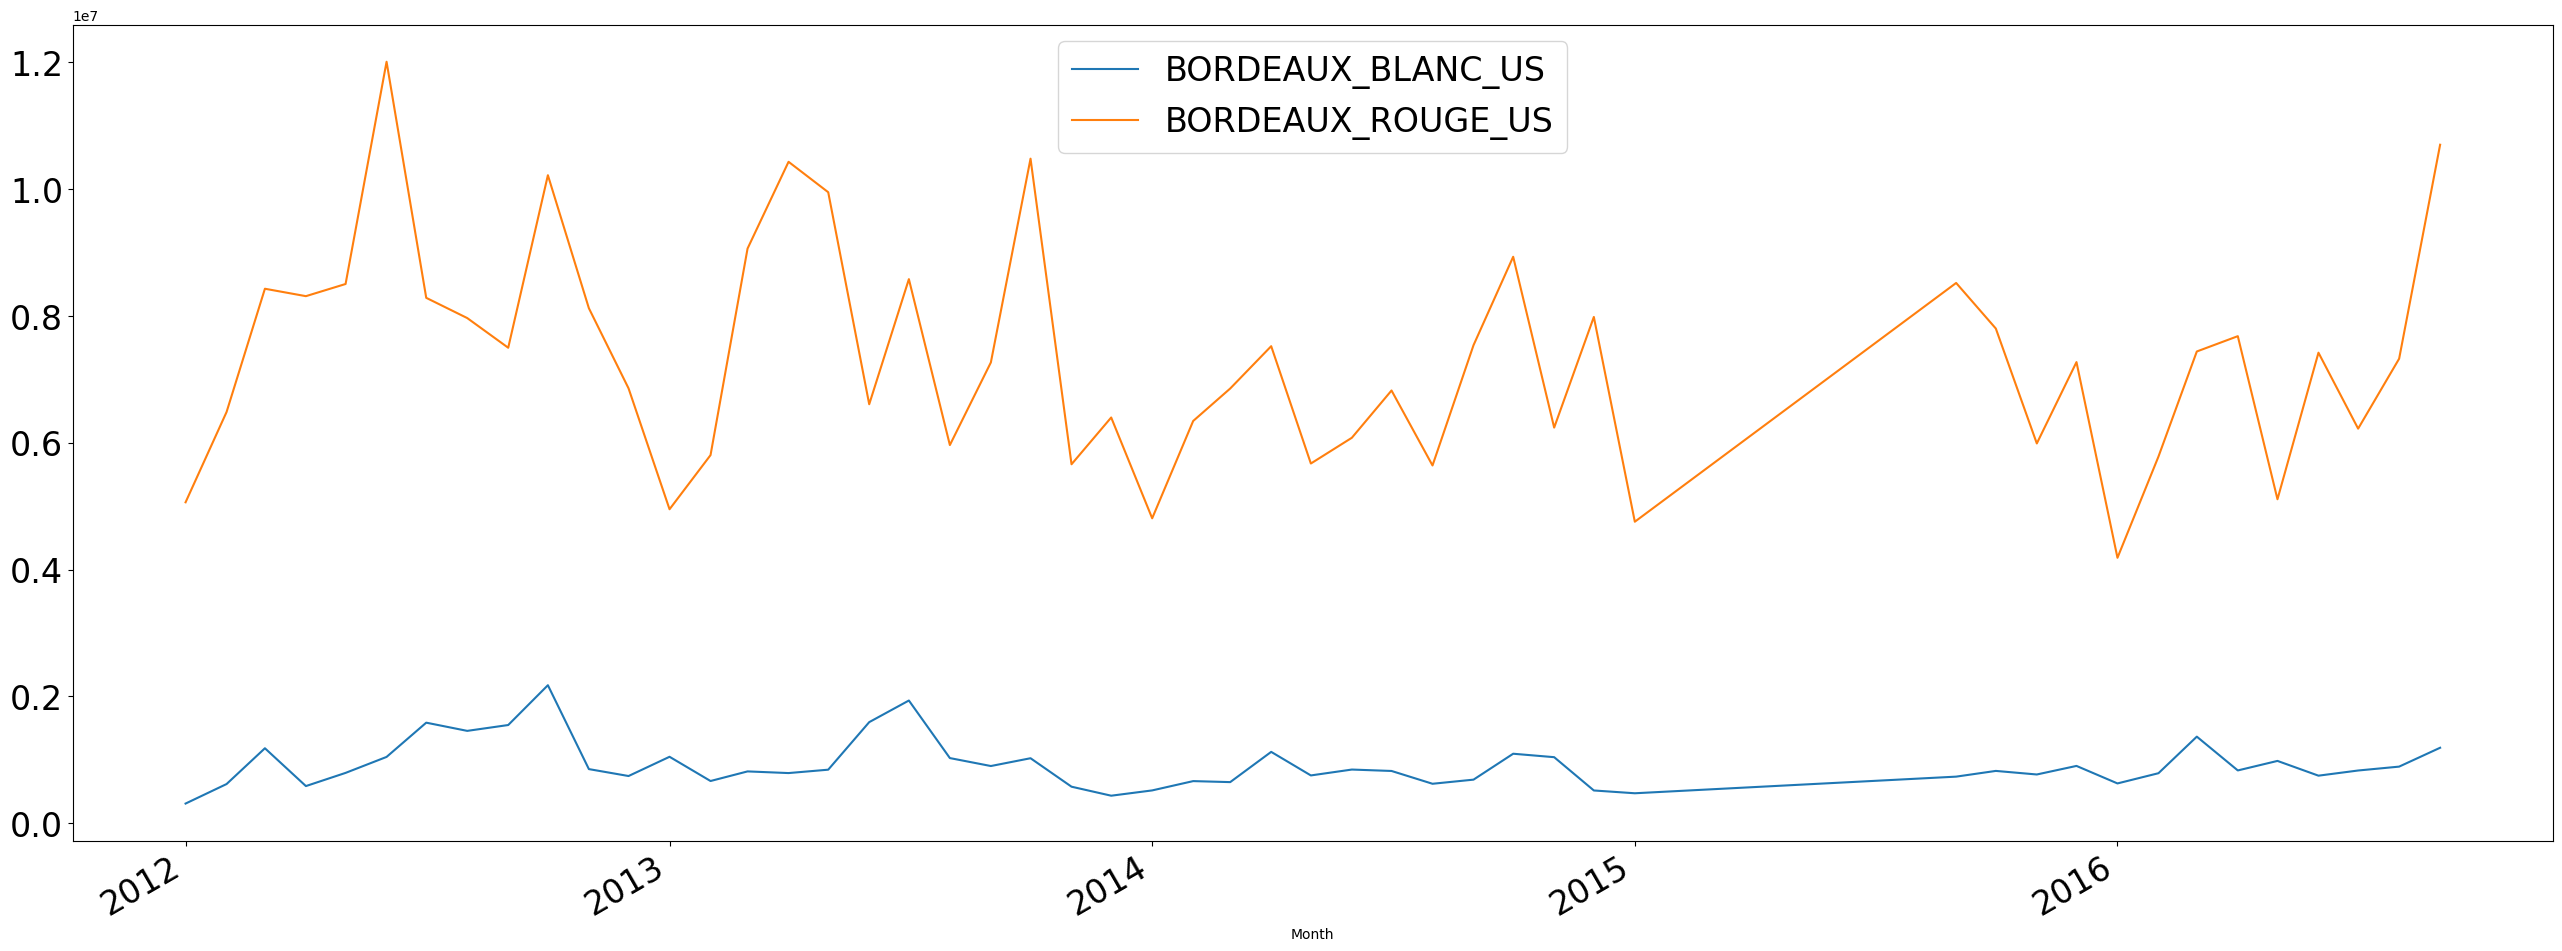

In [7]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    ['BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_US'],
                                    fontsize = 24,
                                    figsize=(32 , 12)).legend(loc='best', fontsize=24)

In [8]:
CN_columns = [col for col in French_Wine_Export_in_Euros_DF.columns if col.endswith('_CN') ]
French_Wine_Export_in_Euros_DF[CN_columns].describe()


ALSACE_BLANC_CN  BEAUJOLAIS_ROUGE_CN  BORDEAUX_BLANC_CN  \
count        50.000000             50.00000       5.000000e+01   
mean     119348.360000         130292.47000       4.993186e+05   
std       65116.609016         102214.45714       2.936971e+05   
min       19546.000000           5833.00000       1.678740e+05   
25%       82278.500000          66206.50000       3.117738e+05   
50%       98656.000000          98427.50000       4.148980e+05   
75%      161694.000000         158673.75000       5.623658e+05   
max      317661.000000         453985.00000       1.890312e+06   

       BORDEAUX_ROUGE_CN  BOURGOGNE_BLANC_CN  BOURGOGNE_ROUGE_CN  \
count       5.000000e+01           50.000000        5.000000e+01   
mean        1.138432e+07       242575.340000        7.436432e+05   
std         3.081051e+06        99492.736867        4.176045e+05   
min         5.377235e+06        75396.000000        2.725460e+05   
25%         9.737536e+06       171633.250000        4.214805e+05   
50%         1.039686e+07       237099.500000        6.060540e+05   
75%         1.316721e+07       308119.750000        9.648268e+05   
max         1.905088e+07       535157.000000        2.021852e+06   

       CHAMPAGNE_MOUSSEUX_CN  EUROPE_ROUGE_CN  FRANCE_BLANC_CN  \
count           5.000000e+01     5.000000e+01        50.000000   
mean            6.225160e+05     8.313372e+05     12978.062000   
std             3.812781e+05     2.337996e+05     24705.479992   
min             1.976760e+05     3.270090e+05         0.000000   
25%             3.897600e+05     6.529608e+05      1607.250000   
50%             5.299100e+05     8.078685e+05      6237.750000   
75%             7.029695e+05     9.859902e+05     14842.000000   
max             2.103130e+06     1.367882e+06    163701.000000   

       FRANCE_MOUSSEUX_CN  FRANCE_ROUGE_CN  LANGUEDOC_ROUGE_CN  \
count           50.000000        50.000000        5.000000e+01   
mean         93298.256667     11185.281403        1.304245e+06   
std          63521.773261     13888.069451        6.352887e+05   
min          20488.500000       260.500000        4.916860e+05   
25%          46355.750000      4759.017857        9.207640e+05   
50%          82644.583333      8837.333333        1.211934e+06   
75%         118693.250000     12869.584821        1.416010e+06   
max         366064.500000     96564.222222        3.607517e+06   

       LOIRE_BLANC_CN  LOIRE_ROUGE_CN  OTHER_ROUGE_CN  RHÔNE_ROUGE_CN  
count       50.000000       50.000000       50.000000    5.000000e+01  
mean     48771.330000    92016.740000    52969.948000    7.498312e+05  
std      27922.200988    54704.609614    36129.014739    3.592653e+05  
min      16643.500000    15325.000000     6337.750000    1.888270e+05  
25%      31191.250000    54588.250000    28779.650000    5.089532e+05  
50%      37845.750000    77491.500000    44118.875000    7.065070e+05  
75%      62140.375000   119915.500000    62176.000000    9.285735e+05  
max     151128.000000   272948.000000   179114.750000    1.755449e+06

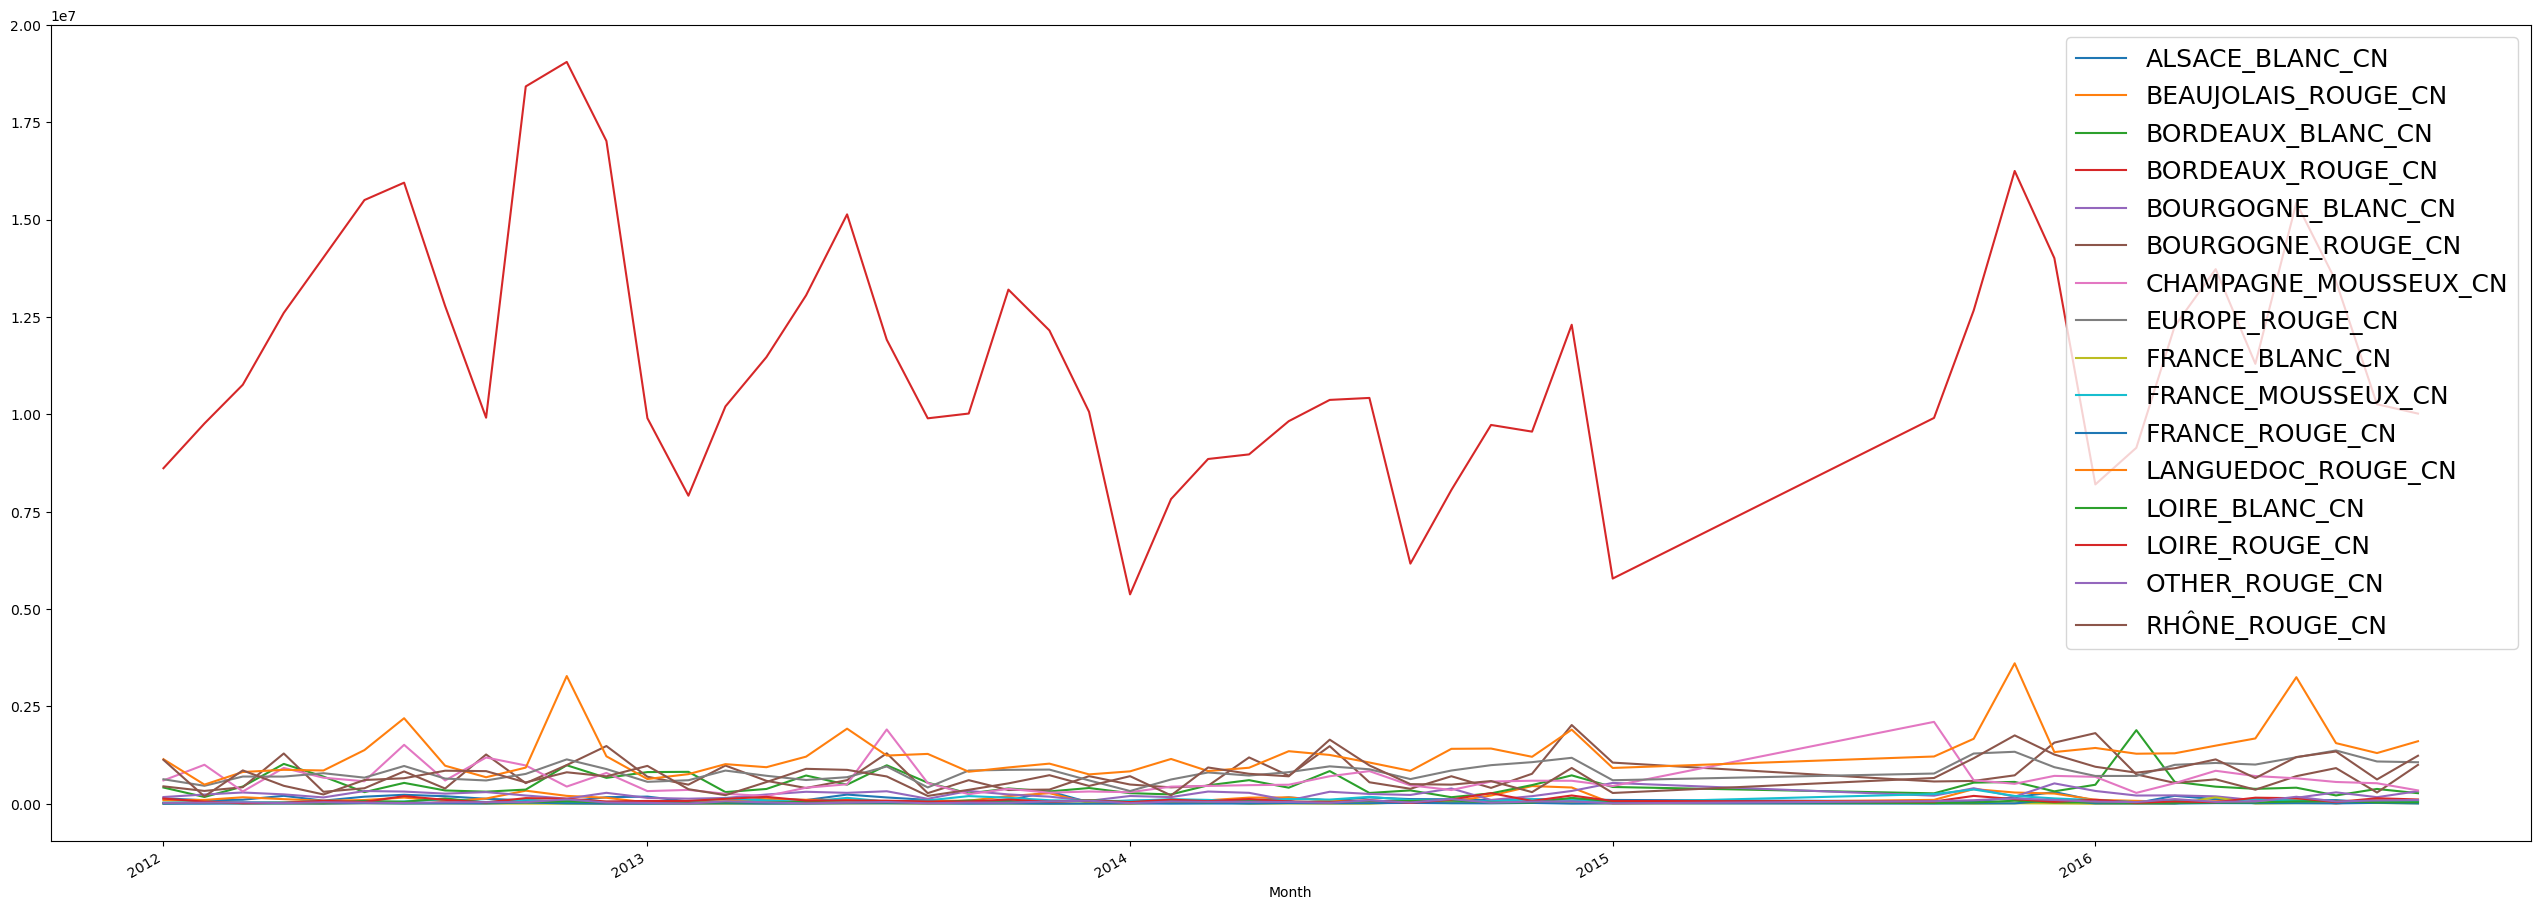

In [9]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    CN_columns,
                                   figsize=(32 , 12)).legend(fontsize=18)

In [10]:
Wines = "ALSACE BEAUJOLAIS BORDEAUX BOURGOGNE CHAMPAGNE EUROPE FRANCE LANGUEDOC LOIRE OTHER RHÔNE".split();
Variants = ['BLANC' , 'MOUSSEUX' , 'ROUGE'];
Countries = ['GB', 'US', 'DE', 'BE', 'CN', 'JP', 'CH', 'HK', 'NL', 'CA' , 'OTHER']



In [11]:
# A lot of possibilities , but only 176 are available ;)
len(Wines) * len(Variants) * len(Countries) 

363

In [12]:
from IPython.display import display


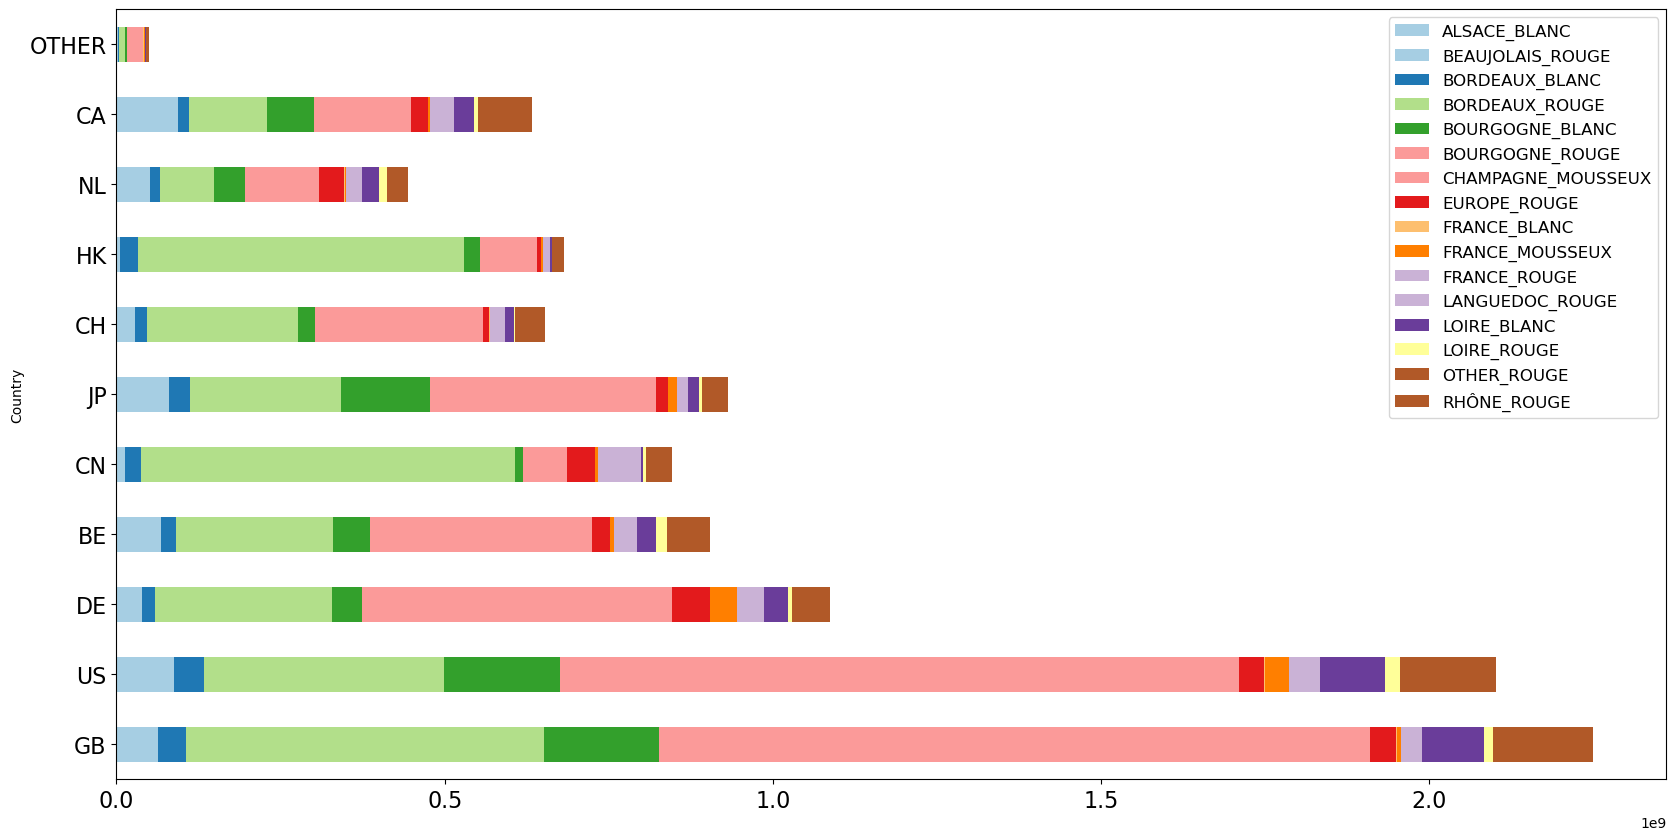

In [13]:
rows = [];
cols = []
for cntry in Countries:
    cntry_columns = [col for col in French_Wine_Export_in_Euros_DF.columns if col.endswith('_' + cntry) ]
    cols = []
    row = [cntry];
    for col in cntry_columns:
        col1 = col.replace('_' + cntry , "")
        sum1 = French_Wine_Export_in_Euros_DF[col].sum()
        row.append(sum1);
        cols.append(col1);
    rows.append(row);

plot_df = pd.DataFrame(rows , columns=['Country'] + cols);

    
plot_df.set_index('Country').plot.barh(stacked=True, figsize=(20,10), fontsize = 16, colormap='Paired').legend(loc='best', fontsize=12)

## Grouping Definition


Here, we start by defining as hierarchical model to forecast wine export by forecasting country and wine type and variant exports.

A wine type export is computed by aggregating (grouping) all variants exported to all countries.

In this section, we describe the definition of the grouping.
Again, for clarity, we restrict our work to some countries and some wine types and variants.


In [14]:

Regions = ['EUROPE', 'AMERICA', 'EUROPE' , 'EUROPE' , 'ASIA' , 'ASIA' , 'EUROPE',  'ASIA', 'EUROPE' , 'AMERICA' , 'OTHER_REGION']
lDict = dict(zip(Countries , Regions));

# simplify !!!!
Variants = ['BLANC' , 'ROUGE'];
Wines = Wines[0:3];
Countries = Countries[0:5]

In [15]:
# Grouping definition
lGroups = {}
lGroups["Country"] = Countries
lGroups["Variant"] = Variants
lGroups["Wine"] = Wines

lHierarchy = {};
lHierarchy['Levels'] = None;
lHierarchy['Data'] = None;
lHierarchy['Groups']= lGroups;
# the most important !!!!
lHierarchy['GroupOrder']= ["Wine", "Variant", "Country"]; # group by Wine first, then by variant, etc
lHierarchy['Type'] = "Grouped";
    


We want here to group first by Wine, then by variant and by country. The hierarchy is automatically created based on available columns. 

The hierarchy has been specified this way :

In [16]:
lHierarchy

{'Levels': None,
 'Data': None,
 'Groups': {'Country': ['GB', 'US', 'DE', 'BE', 'CN'],
  'Variant': ['BLANC', 'ROUGE'],
  'Wine': ['ALSACE', 'BEAUJOLAIS', 'BORDEAUX']},
 'GroupOrder': ['Wine', 'Variant', 'Country'],
 'Type': 'Grouped'}


Column names are of the type "w_v_c" where w is the wine type, v is the variant and c is the country (in the group order). A different group order leads to a differnet hierarchy and differnet models. The group order has a significant business semantics. 

When aggregated , a group name is emptied :
   * **"_BLANC_BE"** is the aggreagtion of all wine types of variant 'BLANC' that are exported to the country 'BE' and
   * **"__CN"** is the aggreagtion of all wine types of all variants that are exported to the country 'CN' (all what China can drink !!!)
   
All these generated names are not always available in our original training dataset (or even in nature, some wine types and variants are not compatible ;). 

The user may also need to adapt the training dataset column names to match the names defined by the automatic grouping (The name 'BORDEAUX_BLANC_DE' reflects a specific group order).

We plot the hierarchy ...


INFO:pyaf.timing:('OPERATION_START', 'HIERARCHICAL_PLOTTING')


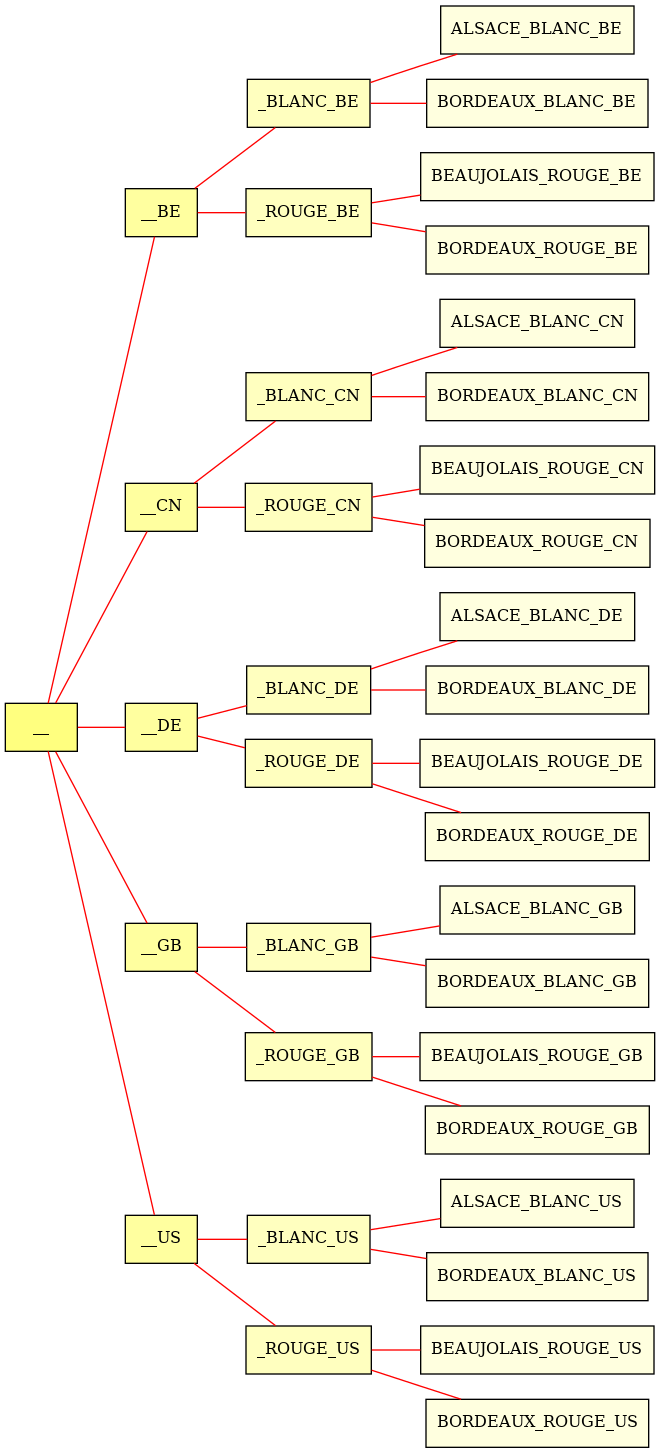

INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.34, 'HIERARCHICAL_PLOTTING')


In [17]:
# create a model to plot the hierarchy.
import pyaf.HierarchicalForecastEngine as hautof
lEngine = hautof.cHierarchicalForecastEngine()


lSignalHierarchy = lEngine.plot_Hierarchy(French_Wine_Export_in_Euros_DF , "Month", "Signal", 1, 
                                          lHierarchy, None);

The strcuture levels have been built :

In [18]:
lSignalHierarchy.mStructure

{0: {'ALSACE_BLANC_BE': [],
  'ALSACE_BLANC_CN': [],
  'ALSACE_BLANC_DE': [],
  'ALSACE_BLANC_GB': [],
  'ALSACE_BLANC_US': [],
  'BEAUJOLAIS_ROUGE_BE': [],
  'BEAUJOLAIS_ROUGE_CN': [],
  'BEAUJOLAIS_ROUGE_DE': [],
  'BEAUJOLAIS_ROUGE_GB': [],
  'BEAUJOLAIS_ROUGE_US': [],
  'BORDEAUX_BLANC_BE': [],
  'BORDEAUX_BLANC_CN': [],
  'BORDEAUX_BLANC_DE': [],
  'BORDEAUX_BLANC_GB': [],
  'BORDEAUX_BLANC_US': [],
  'BORDEAUX_ROUGE_BE': [],
  'BORDEAUX_ROUGE_CN': [],
  'BORDEAUX_ROUGE_DE': [],
  'BORDEAUX_ROUGE_GB': [],
  'BORDEAUX_ROUGE_US': []},
 1: {'_BLANC_BE': ['ALSACE_BLANC_BE', 'BORDEAUX_BLANC_BE'],
  '_BLANC_CN': ['ALSACE_BLANC_CN', 'BORDEAUX_BLANC_CN'],
  '_BLANC_DE': ['ALSACE_BLANC_DE', 'BORDEAUX_BLANC_DE'],
  '_BLANC_GB': ['ALSACE_BLANC_GB', 'BORDEAUX_BLANC_GB'],
  '_BLANC_US': ['ALSACE_BLANC_US', 'BORDEAUX_BLANC_US'],
  '_ROUGE_BE': ['BEAUJOLAIS_ROUGE_BE', 'BORDEAUX_ROUGE_BE'],
  '_ROUGE_CN': ['BEAUJOLAIS_ROUGE_CN', 'BORDEAUX_ROUGE_CN'],
  '_ROUGE_DE': ['BEAUJOLAIS_ROUGE_DE', 'BORDEA

## Hierarchical Modelling

Here, we build a first model on the previous hierarchy. Thsi will build an internal model for each node of the previous graph.

Note that the lower (most detailed) level data are coming from the datset and higher levels are obtained by aggregating previous levels.  

We discard the last 4 months of the dataset and try to forecast their values. 

In [19]:
# create a hierarchical model and train it
import pyaf.HierarchicalForecastEngine as hautof

lEngine = hautof.cHierarchicalForecastEngine()

lSignalVar = "Sales";

#
N = French_Wine_Export_in_Euros_DF.shape[0];
H = 4;
train_df = French_Wine_Export_in_Euros_DF.head(N-H);


lSignalHierarchy = lEngine.train(train_df , lDateColumn, lSignalVar, 1, lHierarchy, None);

INFO:pyaf.timing:('OPERATION_START', 'HIERARCHICAL_TRAINING')
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signals': ['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US', '_BLANC_BE', '_BLANC_CN', '_BLANC_DE', '_BLANC_GB', '_BLANC_US', '_ROUGE_BE', '_ROUGE_CN', '_ROUGE_DE', '_ROUGE_GB', '_ROUGE_US', '__BE', '__CN', '__DE', '__GB', '__US', '__'], 'Horizons': {'ALSACE_BLANC_BE': 1, 'ALSACE_BLANC_CN': 1, 'ALSACE_BLANC_DE': 1, 'ALSACE_BLANC_GB': 1, 'ALSACE_BLANC_US': 1, 'BEAUJOLAIS_ROUGE_BE': 1, 'BEAUJOLAIS_ROUGE_CN': 1, 'BEAUJOLAIS_ROUGE_DE': 1, 'BEAUJOLAIS_ROUGE_GB': 1, 'BEAUJOLAIS_ROUGE_US': 1, 'BORDEAUX_BLANC_BE': 1, '

INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'ALSACE_BLANC_BE', 'Horizon': 1, 'Transformation': 'Diff_ALSACE_BLANC_BE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'ALSACE_BLANC_BE', 'Horizon': 1, 'Transformation': '_ALSACE_BLANC_BE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'ALSACE_BLANC_BE', 'Horizon': 1, 'Transformation': 'RelDiff_ALSACE_BLANC_BE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'ALSACE_BLANC_CN', 'Horizon': 1, 'Transformation': '_ALSACE_BLANC_CN', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'ALSACE_BLANC_BE', 'Horizon': 1, 'Transformation': 'CumSum_ALSACE_BLANC_BE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'ALSACE_BLANC_CN', 'Horizon': 1, 'Transformation': 'Diff_ALSACE_BLANC_CN', 'DecompositionType': 'T+S+R

INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BEAUJOLAIS_ROUGE_CN', 'Horizon': 1, 'Transformation': 'CumSum_BEAUJOLAIS_ROUGE_CN', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.39, ('TRAINING', {'Signal': 'BEAUJOLAIS_ROUGE_BE', 'Horizon': 1, 'Transformation': '_BEAUJOLAIS_ROUGE_BE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BEAUJOLAIS_ROUGE_DE', 'Horizon': 1, 'Transformation': '_BEAUJOLAIS_ROUGE_DE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.41, ('TRAINING', {'Signal': 'BEAUJOLAIS_ROUGE_BE', 'Horizon': 1, 'Transformation': 'Diff_BEAUJOLAIS_ROUGE_BE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BEAUJOLAIS_ROUGE_DE', 'Horizon': 1, 'Transformation': 'Diff_BEAUJOLAIS_ROUGE_DE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.386, ('TRAINING', {'Signal': 'BEAUJOLAIS_ROUGE_BE', 'Hori

INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BORDEAUX_BLANC_DE', 'Horizon': 1, 'Transformation': 'RelDiff_BORDEAUX_BLANC_DE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.367, ('TRAINING', {'Signal': 'BORDEAUX_BLANC_CN', 'Horizon': 1, 'Transformation': '_BORDEAUX_BLANC_CN', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BORDEAUX_BLANC_DE', 'Horizon': 1, 'Transformation': 'CumSum_BORDEAUX_BLANC_DE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.361, ('TRAINING', {'Signal': 'BORDEAUX_BLANC_CN', 'Horizon': 1, 'Transformation': 'Diff_BORDEAUX_BLANC_CN', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.401, ('TRAINING', {'Signal': 'BORDEAUX_BLANC_BE', 'Horizon': 1, 'Transformation': 'CumSum_BORDEAUX_BLANC_BE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BORDEAUX_BLANC_GB', 'Horizon': 1, 'T

INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BORDEAUX_ROUGE_GB', 'Horizon': 1, 'Transformation': 'Diff_BORDEAUX_ROUGE_GB', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.36, ('TRAINING', {'Signal': 'BORDEAUX_ROUGE_CN', 'Horizon': 1, 'Transformation': 'CumSum_BORDEAUX_ROUGE_CN', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BORDEAUX_ROUGE_GB', 'Horizon': 1, 'Transformation': 'RelDiff_BORDEAUX_ROUGE_GB', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.381, ('TRAINING', {'Signal': 'BORDEAUX_ROUGE_CN', 'Horizon': 1, 'Transformation': 'RelDiff_BORDEAUX_ROUGE_CN', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'BORDEAUX_ROUGE_GB', 'Horizon': 1, 'Transformation': 'CumSum_BORDEAUX_ROUGE_GB', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.366, ('TRAINING', {'Signal': 'BORDEAUX_ROUGE_DE', 'Horizon':

INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.368, ('TRAINING', {'Signal': '_BLANC_DE', 'Horizon': 1, 'Transformation': 'CumSum__BLANC_DE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '_BLANC_US', 'Horizon': 1, 'Transformation': 'RelDiff__BLANC_US', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.384, ('TRAINING', {'Signal': '_BLANC_DE', 'Horizon': 1, 'Transformation': 'RelDiff__BLANC_DE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '_BLANC_US', 'Horizon': 1, 'Transformation': 'CumSum__BLANC_US', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.351, ('TRAINING', {'Signal': '_BLANC_GB', 'Horizon': 1, 'Transformation': '__BLANC_GB', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '_ROUGE_BE', 'Horizon': 1, 'Transformation': '__ROUGE_BE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPER

INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '__BE', 'Horizon': 1, 'Transformation': 'CumSum___BE', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.369, ('TRAINING', {'Signal': '_ROUGE_US', 'Horizon': 1, 'Transformation': '__ROUGE_US', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '__CN', 'Horizon': 1, 'Transformation': '___CN', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.368, ('TRAINING', {'Signal': '_ROUGE_US', 'Horizon': 1, 'Transformation': 'Diff__ROUGE_US', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': '__CN', 'Horizon': 1, 'Transformation': 'Diff___CN', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.365, ('TRAINING', {'Signal': '_ROUGE_US', 'Horizon': 1, 'Transformation': 'RelDiff__ROUGE_US', 'DecompositionType': 'T+S+R'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal

INFO:pyaf.timing:('OPERATION_START', ('MODEL_SELECTION', {'Signals': ['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US', '_BLANC_BE', '_BLANC_CN', '_BLANC_DE', '_BLANC_GB', '_BLANC_US', '_ROUGE_BE', '_ROUGE_CN', '_ROUGE_DE', '_ROUGE_GB', '_ROUGE_US', '__BE', '__CN', '__DE', '__GB', '__US', '__'], 'Cores': 8}))
INFO:pyaf.timing:('OPERATION_START', ('VOTING_MODEL_SELECTION', {'Signal': 'ALSACE_BLANC_BE'}))
INFO:pyaf.timing:('OPERATION_START', ('VOTING_MODEL_SELECTION', {'Signal': 'ALSACE_BLANC_CN'}))
INFO:pyaf.timing:('OPERATION_START', ('MODEL_SELECTION_COMPUTE_VOTING_SCORES', 64))
INFO:pyaf.timing:('OPERATION_START', ('VOTI

INFO:pyaf.timing:('OPERATION_START', ('VOTING_MODEL_SELECTION', {'Signal': '_BLANC_CN'}))
INFO:pyaf.timing:('OPERATION_START', ('MODEL_SELECTION_COMPUTE_VOTING_SCORES', 64))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.014, ('VOTING_MODEL_SELECTION', {'Signal': 'BORDEAUX_ROUGE_DE'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.004, ('MODEL_SELECTION_COMPUTE_VOTING_SCORES', 64))
INFO:pyaf.timing:('OPERATION_START', ('VOTING_MODEL_SELECTION', {'Signal': '_BLANC_DE'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.005, ('MODEL_SELECTION_COMPUTE_VOTING_SCORES', 64))
INFO:pyaf.timing:('OPERATION_START', ('MODEL_SELECTION_COMPUTE_VOTING_SCORES', 64))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.013, ('VOTING_MODEL_SELECTION', {'Signal': 'BORDEAUX_ROUGE_GB'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.006, ('MODEL_SELECTION_COMPUTE_VOTING_SCORES', 64))
INFO:pyaf.timing:('OPERATION_START', ('VOTING_MODEL_SELECTION', {'Signal': '_BLANC_GB'}))
INFO:pyaf.timing:('OPERATION_START', ('MODEL_SELE

INFO:pyaf.timing:('OPERATION_START', ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'ALSACE_BLANC_BE', 'Model': '_ALSACE_BLANC_BE_ConstantTrend_residue_zeroCycle[0.0]_residue_NoAR'}))
INFO:pyaf.timing:('OPERATION_START', ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'ALSACE_BLANC_CN', 'Model': '_ALSACE_BLANC_CN_LinearTrend_residue_zeroCycle[0.0]_residue_AR(11)'}))
INFO:pyaf.timing:('OPERATION_START', ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'ALSACE_BLANC_DE', 'Model': '_ALSACE_BLANC_DE_ConstantTrend_residue_Cycle_5_residue_NoAR'}))
INFO:pyaf.timing:('OPERATION_START', ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'ALSACE_BLANC_GB', 'Model': '_ALSACE_BLANC_GB_ConstantTrend_residue_Cycle_None_residue_NoAR'}))
INFO:pyaf.timing:('OPERATION_START', ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'ALSACE_BLANC_US', 'Model': '_ALSACE_BLANC_US_ConstantTrend_residue_Cycle_5_residue_AR(11)'}))
INFO:pyaf.timing:('OPERATION_START', ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'BEAUJOLAIS_ROUGE_BE', 'Model': '_BEAUJOLAIS_ROUGE_BE_PolyTr

INFO:pyaf.timing:('OPERATION_START', ('COMPUTE_PREDICTION_INTERVALS', {'Signal': 'BORDEAUX_BLANC_US'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.03, ('COMPUTE_PREDICTION_INTERVALS', {'Signal': 'BORDEAUX_BLANC_DE'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.057, ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'BORDEAUX_ROUGE_BE', 'Model': '_BORDEAUX_ROUGE_BE_Lag1Trend_residue_Cycle_5_residue_AR(11)'}))
INFO:pyaf.timing:('OPERATION_START', ('COMPUTE_PREDICTION_INTERVALS', {'Signal': 'BORDEAUX_ROUGE_BE'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.037, ('COMPUTE_PREDICTION_INTERVALS', {'Signal': 'BORDEAUX_BLANC_BE'}))
INFO:pyaf.timing:('OPERATION_START', ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'BORDEAUX_ROUGE_DE', 'Model': 'Diff_BORDEAUX_ROUGE_DE_LinearTrend_residue_zeroCycle[0.0]_residue_NoAR'}))
INFO:pyaf.timing:('OPERATION_START', ('UPDATE_BEST_MODEL_PERFS', {'Signal': 'BORDEAUX_ROUGE_GB', 'Model': '_BORDEAUX_ROUGE_GB_Lag1Trend_residue_Cycle_None_residue_NoAR'}))
INFO:pyaf.timing:('OP

INFO:pyaf.timing:('OPERATION_START', ('COMPUTE_PREDICTION_INTERVALS', {'Signal': '_ROUGE_GB'}))
INFO:pyaf.timing:('OPERATION_START', ('COMPUTE_PREDICTION_INTERVALS', {'Signal': '__CN'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.055, ('UPDATE_BEST_MODEL_PERFS', {'Signal': '_ROUGE_US', 'Model': '__ROUGE_US_LinearTrend_residue_Cycle_5_residue_AR(11)'}))
INFO:pyaf.timing:('OPERATION_START', ('COMPUTE_PREDICTION_INTERVALS', {'Signal': '_ROUGE_US'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.032, ('COMPUTE_PREDICTION_INTERVALS', {'Signal': '_ROUGE_CN'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.053, ('UPDATE_BEST_MODEL_PERFS', {'Signal': '__BE', 'Model': '___BE_Lag1Trend_residue_Cycle_5_residue_AR(11)'}))
INFO:pyaf.timing:('OPERATION_START', ('COMPUTE_PREDICTION_INTERVALS', {'Signal': '__BE'}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.046, ('COMPUTE_PREDICTION_INTERVALS', {'Signal': '_BLANC_US'}))
INFO:pyaf.timing:('OPERATION_START', ('UPDATE_BEST_MODEL_PERFS', {'Signal': '__D

INFO:pyaf.timing:('OPERATION_END_ELAPSED', 2.831, ('FORECASTING', {'Signals': ['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US', '_BLANC_BE', '_BLANC_CN', '_BLANC_DE', '_BLANC_GB', '_BLANC_US', '_ROUGE_BE', '_ROUGE_CN', '_ROUGE_DE', '_ROUGE_GB', '_ROUGE_US', '__BE', '__CN', '__DE', '__GB', '__US', '__'], 'Horizon': 1}))
INFO:pyaf.hierarchical:FORECASTING_HIERARCHICAL_MODEL_COMBINATION_METHODS ['BU']
INFO:pyaf.hierarchical:FORECASTING_HIERARCHICAL_MODEL_BOTTOM_UP_METHOD BU
INFO:pyaf.hierarchical:FORECASTING_HIERARCHICAL_MODEL_OPTIMAL_COMBINATION_METHOD
INFO:pyaf.hierarchical:STRUCTURE [0, 1, 2, 3]
INFO:pyaf.hierarchical:DAT

INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_FIT_PERF {'Signal': 'BEAUJOLAIS_ROUGE_DE_BU_Forecast', 'Length': 36, 'MAPE': 0.6013, 'RMSE': 267334.4691, 'MAE': 119940.8889, 'SMAPE': 0.5132, 'DiffSMAPE': 0.5132, 'MASE': 0.5748, 'RMSSE': 0.7356, 'ErrorMean': -89894.5, 'ErrorStdDev': 251767.1488, 'R2': -0.1104, 'Pearson': 0.1886, 'MedAE': 33174.5, 'LnQ': 29.2411, 'KS': 0.3889, 'KendallTau': 0.147, 'MannWhitneyU': 672.0, 'AUC': 0.5185}
INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_VALID_PERF {'Signal': 'BEAUJOLAIS_ROUGE_DE_BU_Forecast', 'Length': 9, 'MAPE': 0.5505, 'RMSE': 161252.3109, 'MAE': 100688.2778, 'SMAPE': 0.5862, 'DiffSMAPE': 0.5862, 'MASE': 0.5693, 'RMSSE': 0.6925, 'ErrorMean': -64710.7222, 'ErrorStdDev': 147698.4435, 'R2': -0.23, 'Pearson': -0.2138, 'MedAE': 46252.0, 'LnQ': 6.1587, 'KS': 0.5556, 'KendallTau': -0.2357, 'MannWhitneyU': 31.0, 'AUC': 0.3827}
INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_FIT_PERF {'Signal': 'BEAUJOLAIS_ROUGE_GB_BU_Forecast', 'Length': 36, 'MA

INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_VALID_PERF {'Signal': 'BORDEAUX_ROUGE_CN_BU_Forecast', 'Length': 9, 'MAPE': 0.2216, 'RMSE': 2646130.4232, 'MAE': 2110502.469, 'SMAPE': 0.1932, 'DiffSMAPE': 0.1932, 'MASE': 0.7022, 'RMSSE': 0.7932, 'ErrorMean': -382238.5783, 'ErrorStdDev': 2618377.3384, 'R2': 0.2772, 'Pearson': 0.58, 'MedAE': 1670838.4068, 'LnQ': 0.6509, 'KS': 0.4444, 'KendallTau': 0.6111, 'MannWhitneyU': 47.0, 'AUC': 0.5802}
INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_FIT_PERF {'Signal': 'BORDEAUX_ROUGE_DE_BU_Forecast', 'Length': 36, 'MAPE': 0.3441, 'RMSE': 2184832.27, 'MAE': 1711130.9185, 'SMAPE': 0.2933, 'DiffSMAPE': 0.2933, 'MASE': 1.1236, 'RMSSE': 0.983, 'ErrorMean': -3709.3335, 'ErrorStdDev': 2184829.1212, 'R2': -0.0582, 'Pearson': -0.3013, 'MedAE': 1405776.3006, 'LnQ': 5.3261, 'KS': 0.4722, 'KendallTau': -0.0952, 'MannWhitneyU': 629.0, 'AUC': 0.4853}
INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_VALID_PERF {'Signal': 'BORDEAUX_ROUGE_DE_BU_Forecast', 'Length

INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_FIT_PERF {'Signal': '_ROUGE_CN_BU_Forecast', 'Length': 36, 'MAPE': 0.3894, 'RMSE': 5907365.5027, 'MAE': 4715035.1564, 'SMAPE': 0.5149, 'DiffSMAPE': 0.5149, 'MASE': 2.2381, 'RMSSE': 2.1126, 'ErrorMean': -3569399.1416, 'ErrorStdDev': 4707053.9566, 'R2': -2.4683, 'Pearson': -0.1668, 'MedAE': 4492303.5201, 'LnQ': 19.131, 'KS': 0.5278, 'KendallTau': -0.1365, 'MannWhitneyU': 1029.0, 'AUC': 0.794}
INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_VALID_PERF {'Signal': '_ROUGE_CN_BU_Forecast', 'Length': 9, 'MAPE': 0.2257, 'RMSE': 2692389.9851, 'MAE': 2147491.3052, 'SMAPE': 0.1948, 'DiffSMAPE': 0.1948, 'MASE': 0.7019, 'RMSSE': 0.7913, 'ErrorMean': -362473.5634, 'ErrorStdDev': 2667878.6981, 'R2': 0.2881, 'Pearson': 0.5939, 'MedAE': 1623173.7811, 'LnQ': 0.6697, 'KS': 0.4444, 'KendallTau': 0.6111, 'MannWhitneyU': 47.0, 'AUC': 0.5802}
INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_FIT_PERF {'Signal': '_ROUGE_DE_BU_Forecast', 'Length': 36, 'MAPE': 0.

INFO:pyaf.hierarchical:REPORT_COMBINED_FORECASTS_VALID_PERF {'Signal': '___BU_Forecast', 'Length': 9, 'MAPE': 0.1236, 'RMSE': 5742427.2087, 'MAE': 4493337.5203, 'SMAPE': 0.1155, 'DiffSMAPE': 0.1155, 'MASE': 0.637, 'RMSSE': 0.6672, 'ErrorMean': 619583.2197, 'ErrorStdDev': 5708904.1752, 'R2': 0.3523, 'Pearson': 0.6534, 'MedAE': 4397422.0232, 'LnQ': 0.2117, 'KS': 0.3333, 'KendallTau': 0.5, 'MannWhitneyU': 42.0, 'AUC': 0.5185}
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 13.239, 'HIERARCHICAL_TRAINING')


In [20]:
French_Wine_Export_in_Euros_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Columns: 177 entries, Month to RHÔNE_ROUGE_US
dtypes: datetime64[ns](1), float64(56), int64(120)
memory usage: 69.3 KB


In [21]:
lInfo = lEngine.to_dict()
lInfo

{'Structure': {0: {'ALSACE_BLANC_BE': [],
   'ALSACE_BLANC_CN': [],
   'ALSACE_BLANC_DE': [],
   'ALSACE_BLANC_GB': [],
   'ALSACE_BLANC_US': [],
   'BEAUJOLAIS_ROUGE_BE': [],
   'BEAUJOLAIS_ROUGE_CN': [],
   'BEAUJOLAIS_ROUGE_DE': [],
   'BEAUJOLAIS_ROUGE_GB': [],
   'BEAUJOLAIS_ROUGE_US': [],
   'BORDEAUX_BLANC_BE': [],
   'BORDEAUX_BLANC_CN': [],
   'BORDEAUX_BLANC_DE': [],
   'BORDEAUX_BLANC_GB': [],
   'BORDEAUX_BLANC_US': [],
   'BORDEAUX_ROUGE_BE': [],
   'BORDEAUX_ROUGE_CN': [],
   'BORDEAUX_ROUGE_DE': [],
   'BORDEAUX_ROUGE_GB': [],
   'BORDEAUX_ROUGE_US': []},
  1: {'_BLANC_BE': ['ALSACE_BLANC_BE', 'BORDEAUX_BLANC_BE'],
   '_BLANC_CN': ['ALSACE_BLANC_CN', 'BORDEAUX_BLANC_CN'],
   '_BLANC_DE': ['ALSACE_BLANC_DE', 'BORDEAUX_BLANC_DE'],
   '_BLANC_GB': ['ALSACE_BLANC_GB', 'BORDEAUX_BLANC_GB'],
   '_BLANC_US': ['ALSACE_BLANC_US', 'BORDEAUX_BLANC_US'],
   '_ROUGE_BE': ['BEAUJOLAIS_ROUGE_BE', 'BORDEAUX_ROUGE_BE'],
   '_ROUGE_CN': ['BEAUJOLAIS_ROUGE_CN', 'BORDEAUX_ROUGE_CN'],
   '_R

In [22]:
lInfo['Structure']

{0: {'ALSACE_BLANC_BE': [],
  'ALSACE_BLANC_CN': [],
  'ALSACE_BLANC_DE': [],
  'ALSACE_BLANC_GB': [],
  'ALSACE_BLANC_US': [],
  'BEAUJOLAIS_ROUGE_BE': [],
  'BEAUJOLAIS_ROUGE_CN': [],
  'BEAUJOLAIS_ROUGE_DE': [],
  'BEAUJOLAIS_ROUGE_GB': [],
  'BEAUJOLAIS_ROUGE_US': [],
  'BORDEAUX_BLANC_BE': [],
  'BORDEAUX_BLANC_CN': [],
  'BORDEAUX_BLANC_DE': [],
  'BORDEAUX_BLANC_GB': [],
  'BORDEAUX_BLANC_US': [],
  'BORDEAUX_ROUGE_BE': [],
  'BORDEAUX_ROUGE_CN': [],
  'BORDEAUX_ROUGE_DE': [],
  'BORDEAUX_ROUGE_GB': [],
  'BORDEAUX_ROUGE_US': []},
 1: {'_BLANC_BE': ['ALSACE_BLANC_BE', 'BORDEAUX_BLANC_BE'],
  '_BLANC_CN': ['ALSACE_BLANC_CN', 'BORDEAUX_BLANC_CN'],
  '_BLANC_DE': ['ALSACE_BLANC_DE', 'BORDEAUX_BLANC_DE'],
  '_BLANC_GB': ['ALSACE_BLANC_GB', 'BORDEAUX_BLANC_GB'],
  '_BLANC_US': ['ALSACE_BLANC_US', 'BORDEAUX_BLANC_US'],
  '_ROUGE_BE': ['BEAUJOLAIS_ROUGE_BE', 'BORDEAUX_ROUGE_BE'],
  '_ROUGE_CN': ['BEAUJOLAIS_ROUGE_CN', 'BORDEAUX_ROUGE_CN'],
  '_ROUGE_DE': ['BEAUJOLAIS_ROUGE_DE', 'BORDEA

In [23]:
lInfo['Models'].keys()

dict_keys(['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US', '_BLANC_BE', '_BLANC_CN', '_BLANC_DE', '_BLANC_GB', '_BLANC_US', '_ROUGE_BE', '_ROUGE_CN', '_ROUGE_DE', '_ROUGE_GB', '_ROUGE_US', '__BE', '__CN', '__DE', '__GB', '__US', '__'])

In [24]:
lInfo['Models']['BORDEAUX_ROUGE_CN']

{'Dataset': {'Time': {'TimeVariable': 'Month',
   'TimeMin': '2012-01-01 00:00:00',
   'TimeMax': '2016-05-01 00:00:00',
   'TimeDelta': '<DateOffset: months=1>',
   'Horizon': 1},
  'Signal': 'BORDEAUX_ROUGE_CN',
  'Training_Signal_Length': 46},
 'Model': {'Best_Decomposition': 'Diff_BORDEAUX_ROUGE_CN_ConstantTrend_residue_zeroCycle[0.0]_residue_AR(11)',
  'Signal_Decomposition_Type': 'T+S+R',
  'Signal_Transoformation': 'Difference',
  'Trend': 'ConstantTrend',
  'Cycle': 'NoCycle',
  'AR_Model': 'AR'},
 'Complexity': {'Decomposition': 'S',
  'Transformation': 'M',
  'Trend': 'S',
  'Cycle': 'S',
  'AR': 'L'},
 'Model_Selection_Criterion': 'MASE',
 'Model_Performance': {1: {'Signal': 'BORDEAUX_ROUGE_CN_Forecast_1',
   'Length': 9,
   'MAPE': 0.2216,
   'RMSE': 2646130.4232,
   'MAE': 2110502.469,
   'SMAPE': 0.1932,
   'DiffSMAPE': 0.1932,
   'MASE': 0.7022,
   'RMSSE': 0.7932,
   'ErrorMean': -382238.5783,
   'ErrorStdDev': 2618377.3384,
   'R2': 0.2772,
   'Pearson': 0.58,
   'MedA

In [25]:
perfs = [];
for model in sorted(lInfo['Models'].keys()):
    lPerf = lInfo['Models'][model]['Model_Performance'][1]
    perfs.append([model , lPerf['RMSE'] , lPerf['MAPE']])
df_perf = pd.DataFrame(perfs , columns=['Model' , 'RMSE' , 'MAPE']);
df_perf = df_perf.sort_values(by = ['MAPE'])
print(df_perf)

                  Model          RMSE    MAPE
2       ALSACE_BLANC_DE  8.449780e+04  0.1257
30                   __  5.613939e+06  0.1273
13    BORDEAUX_BLANC_GB  9.993669e+04  0.1330
22            _BLANC_DE  1.416086e+05  0.1370
29            _ROUGE_US  1.431642e+06  0.1389
3       ALSACE_BLANC_GB  6.648017e+04  0.1402
23            _BLANC_GB  1.941959e+05  0.1522
34                 __GB  1.567222e+06  0.1579
18    BORDEAUX_ROUGE_GB  1.259435e+06  0.1592
28            _ROUGE_GB  1.442702e+06  0.1611
15    BORDEAUX_ROUGE_BE  6.597966e+05  0.1623
25            _ROUGE_BE  7.185125e+05  0.1646
24            _BLANC_US  3.665407e+05  0.1722
35                 __US  1.671136e+06  0.1733
4       ALSACE_BLANC_US  1.306068e+05  0.1779
31                 __BE  1.296406e+06  0.2011
11    BORDEAUX_BLANC_CN  4.908890e+05  0.2020
19    BORDEAUX_ROUGE_US  1.412616e+06  0.2027
33                 __DE  1.351511e+06  0.2130
27            _ROUGE_DE  1.039192e+06  0.2198
16    BORDEAUX_ROUGE_CN  2.646130e

INFO:pyaf.timing:('OPERATION_START', 'HIERARCHICAL_PLOTTING')


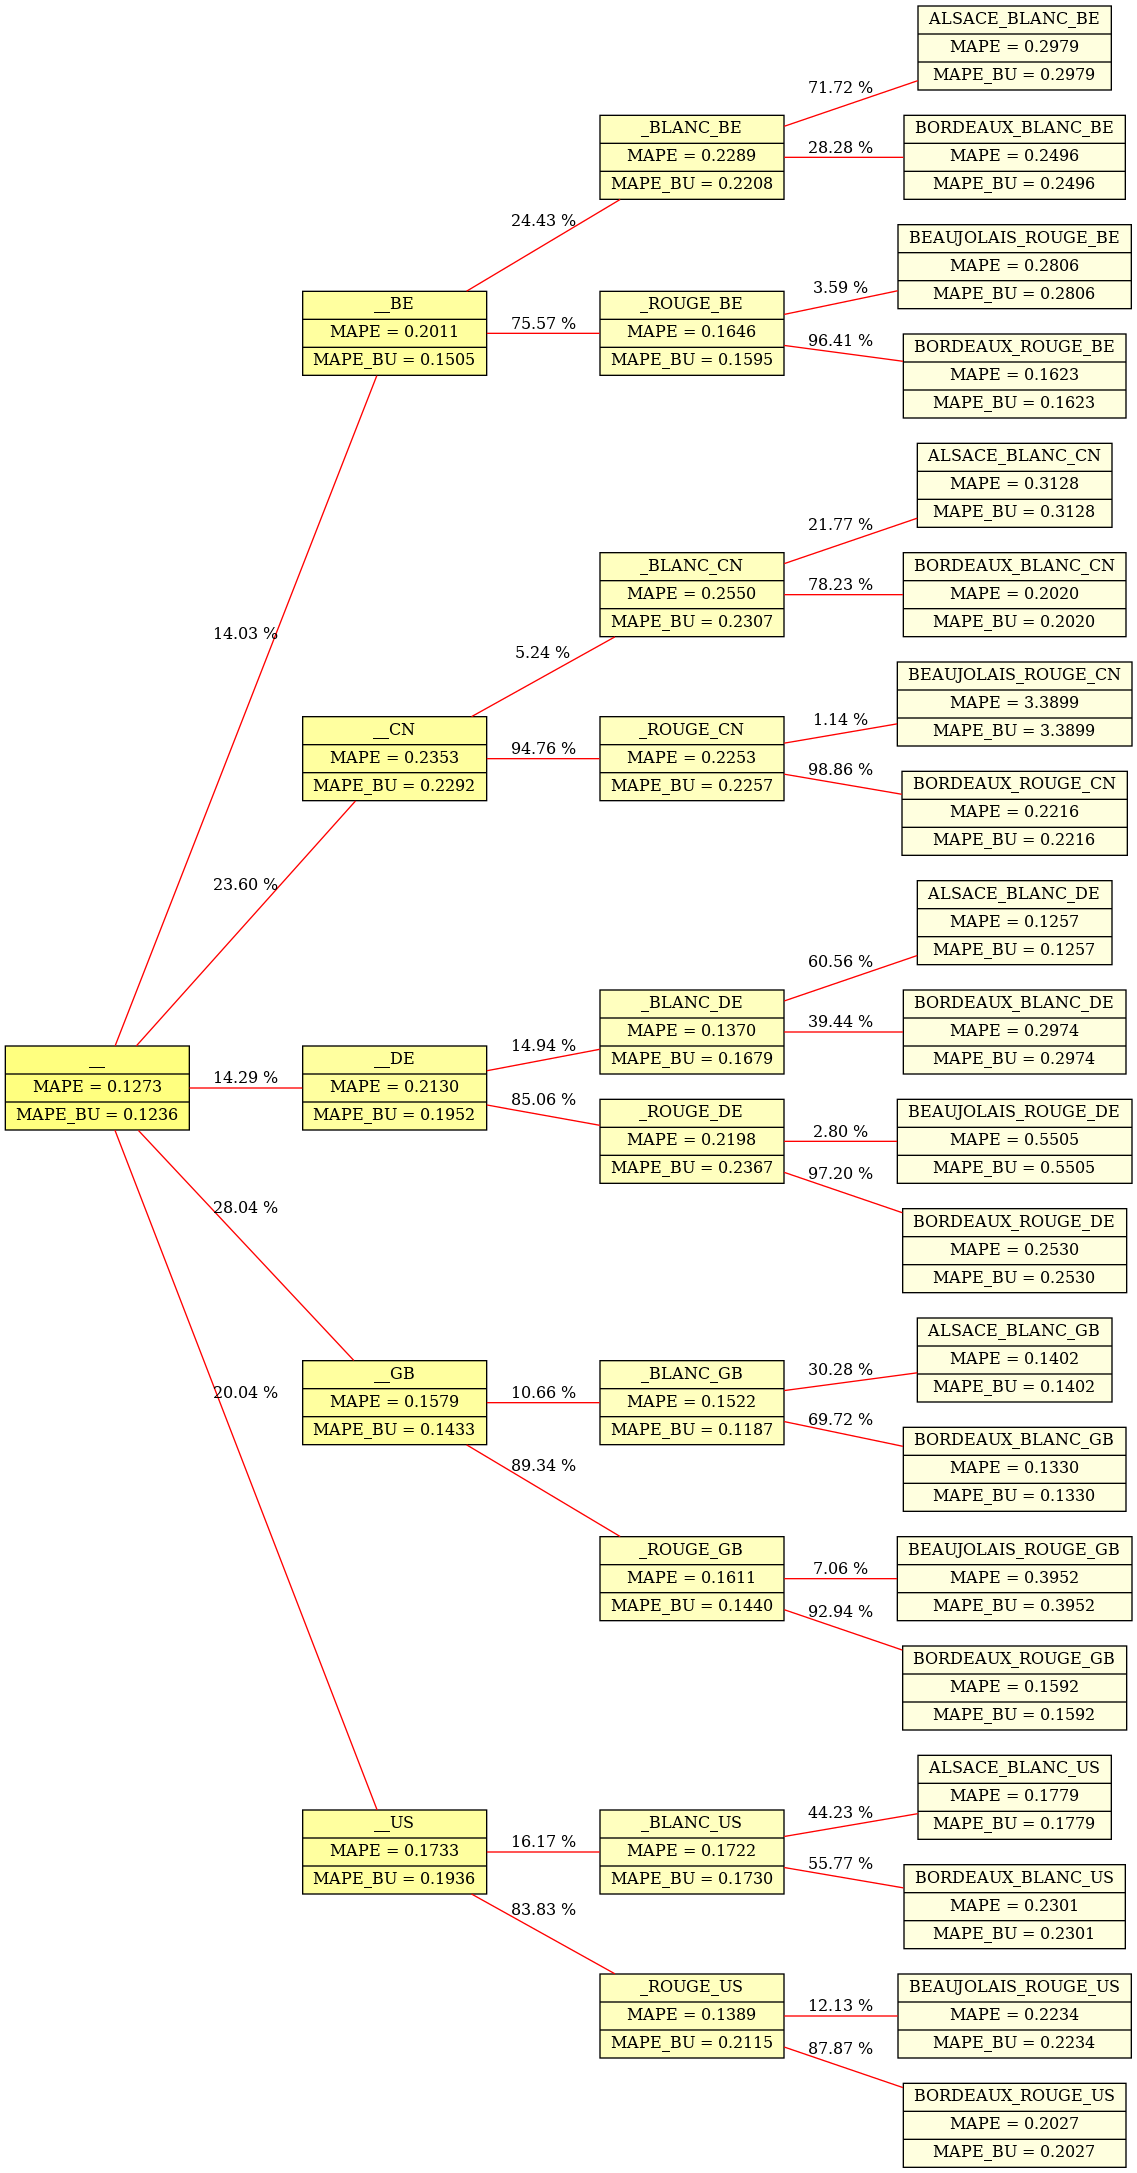

INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.374, 'HIERARCHICAL_PLOTTING')


In [26]:
lEngine.mSignalHierarchy.plot()

In [27]:
CN_Model = lEngine.mSignalHierarchy.mModels.mSignalDecomposition.mBestModels['__CN'] # __CN is at hierarchical level 2

In [28]:
CN_Model.to_dict()

{'Dataset': {'Time': {'TimeVariable': 'Month',
   'TimeMin': '2012-01-01 00:00:00',
   'TimeMax': '2016-05-01 00:00:00',
   'TimeDelta': '<DateOffset: months=1>',
   'Horizon': 1},
  'Signal': '__CN',
  'Training_Signal_Length': 46},
 'Model': {'Best_Decomposition': 'Diff___CN_ConstantTrend_residue_Cycle_None_residue_AR(11)',
  'Signal_Decomposition_Type': 'T+S+R',
  'Signal_Transoformation': 'Difference',
  'Trend': 'ConstantTrend',
  'Cycle': 'Cycle_None',
  'AR_Model': 'AR'},
 'Complexity': {'Decomposition': 'S',
  'Transformation': 'M',
  'Trend': 'S',
  'Cycle': 'S',
  'AR': 'L'},
 'Model_Selection_Criterion': 'MASE',
 'Model_Performance': {1: {'Signal': '__CN_Forecast_1',
   'Length': 9,
   'MAPE': 0.2353,
   'RMSE': 2852608.781,
   'MAE': 2276336.9642,
   'SMAPE': 0.1973,
   'DiffSMAPE': 0.1973,
   'MASE': 0.7336,
   'RMSSE': 0.8382,
   'ErrorMean': -122512.6866,
   'ErrorStdDev': 2849976.7542,
   'R2': 0.1925,
   'Pearson': 0.4456,
   'MedAE': 1562210.67,
   'LnQ': 0.6878,
   '

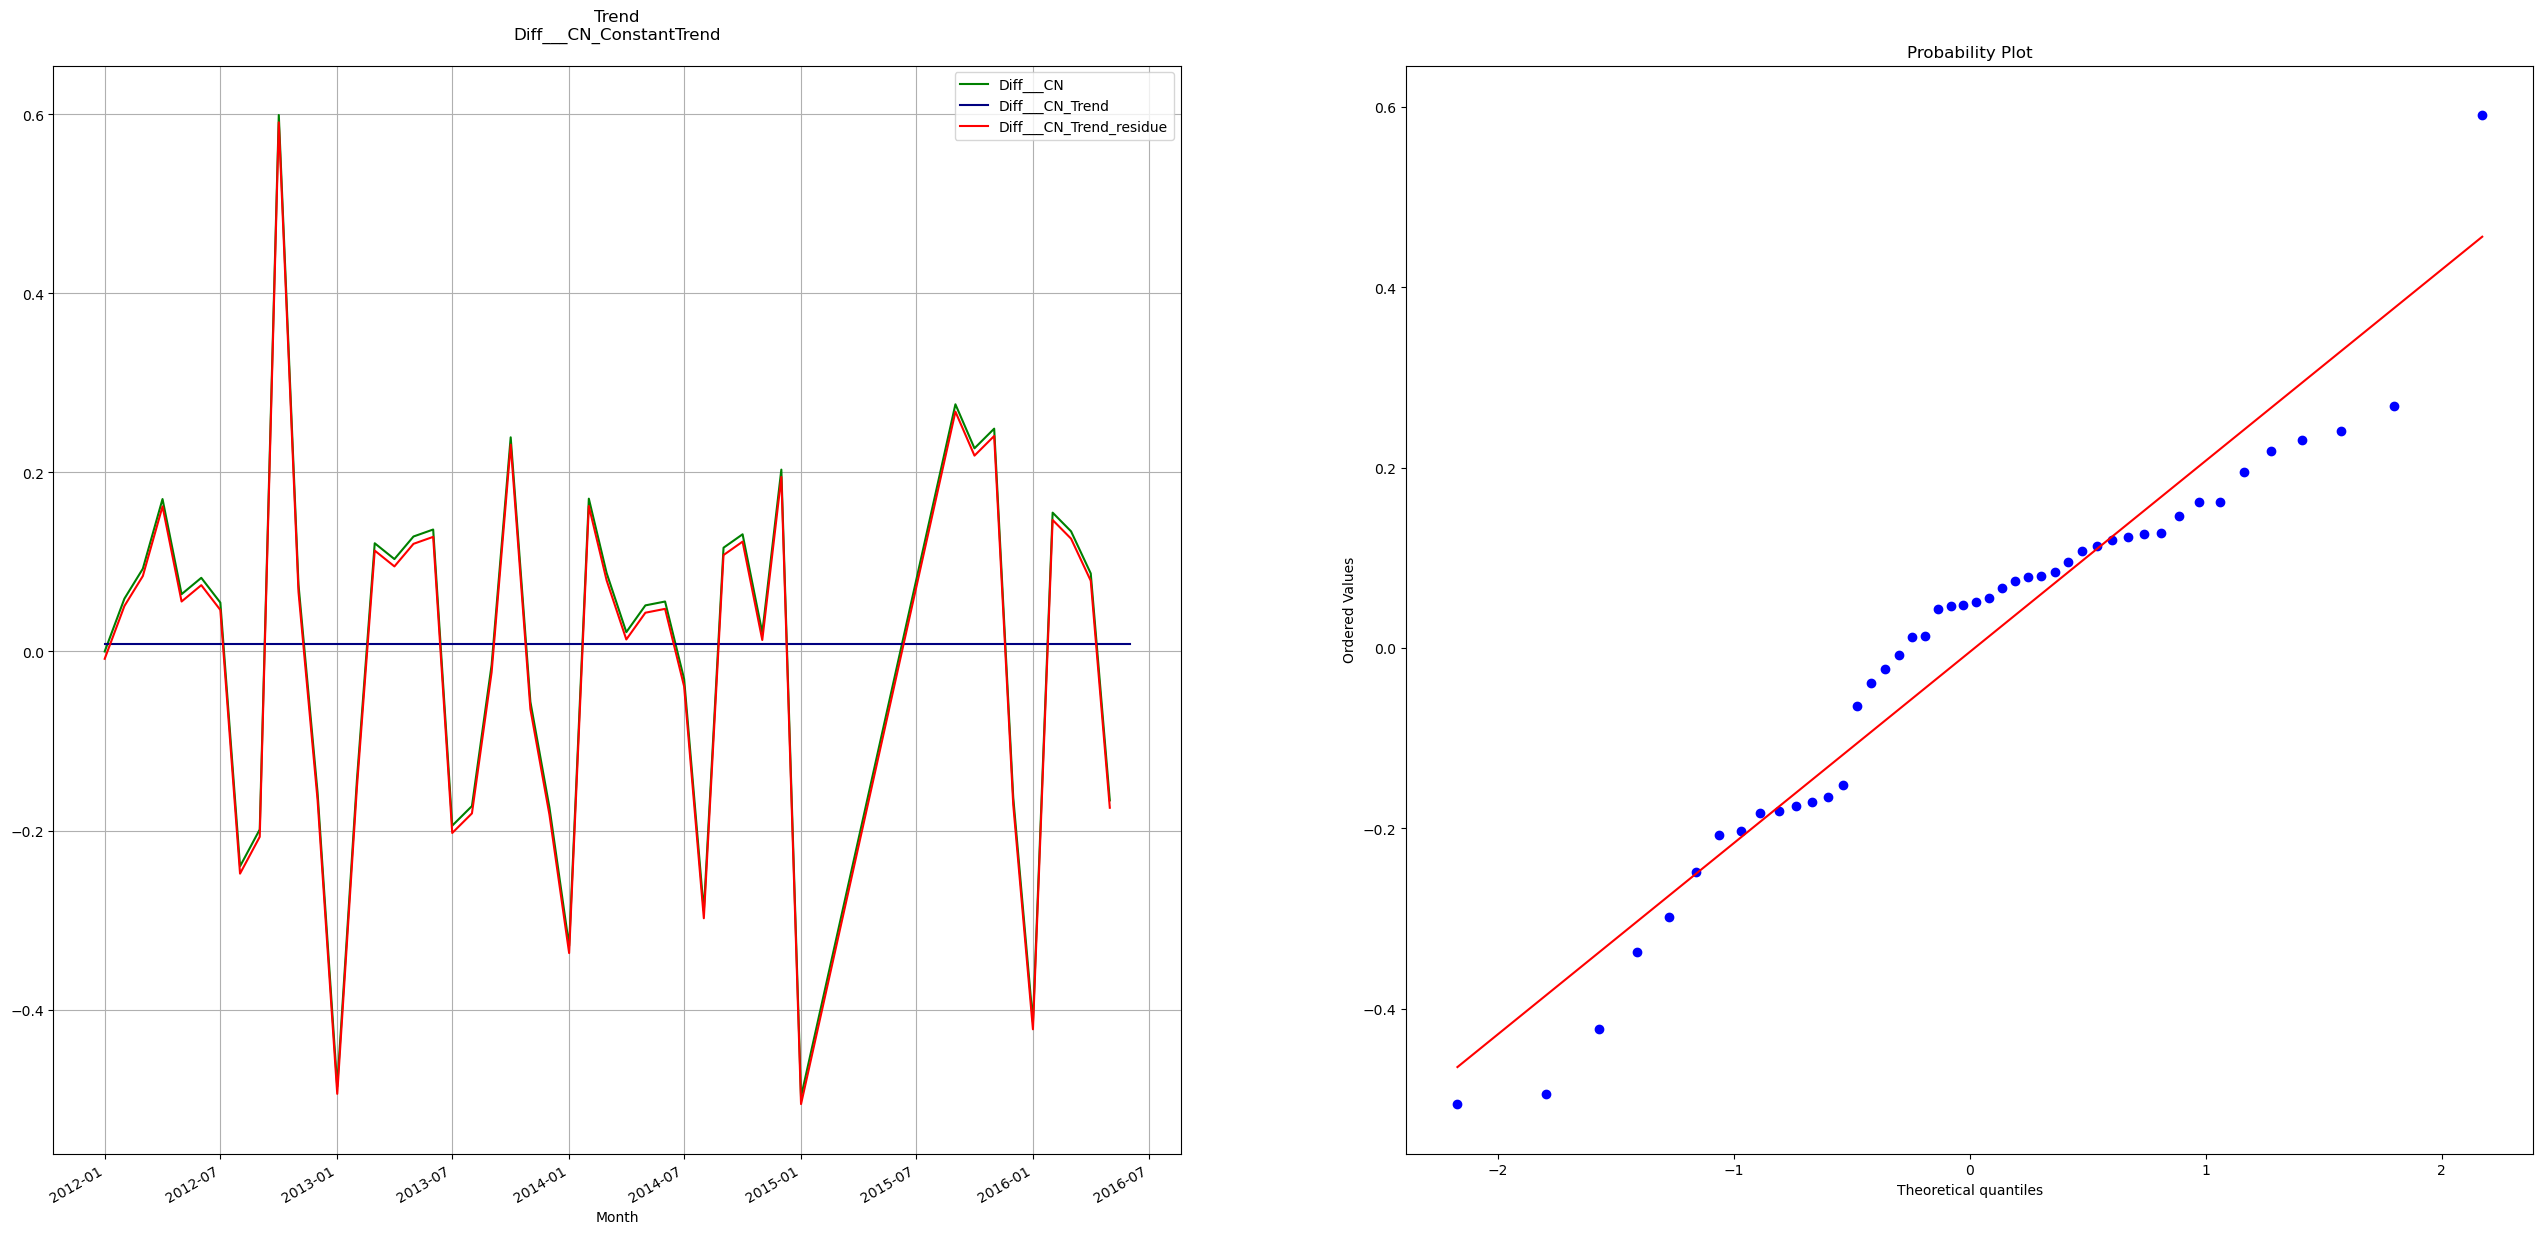

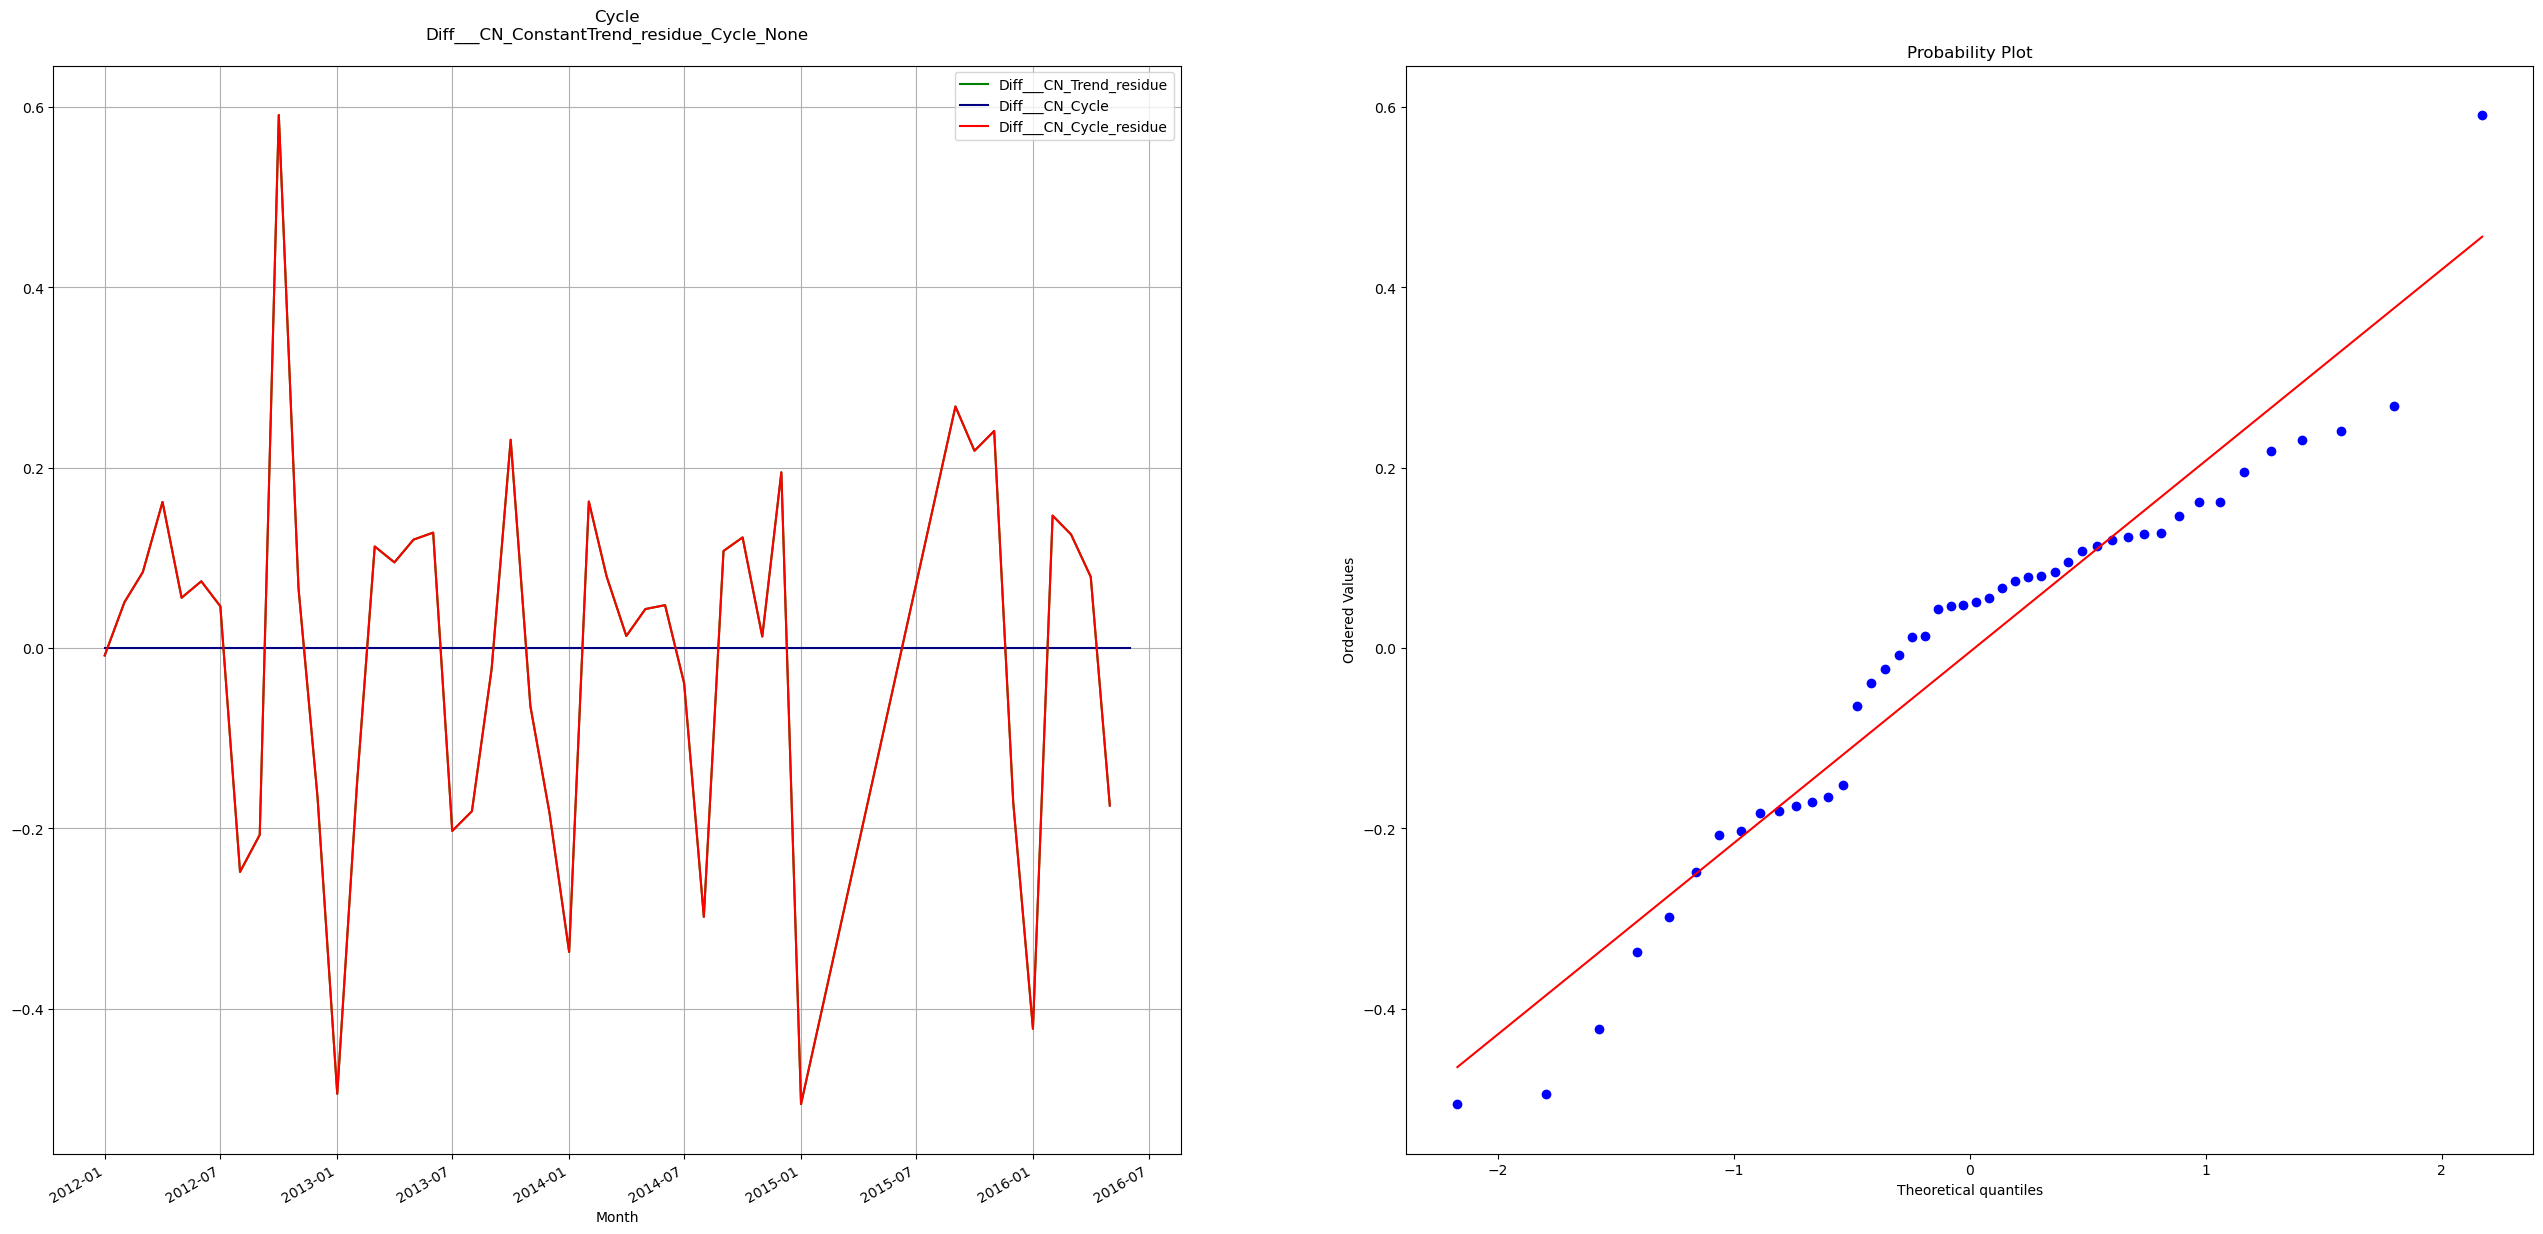

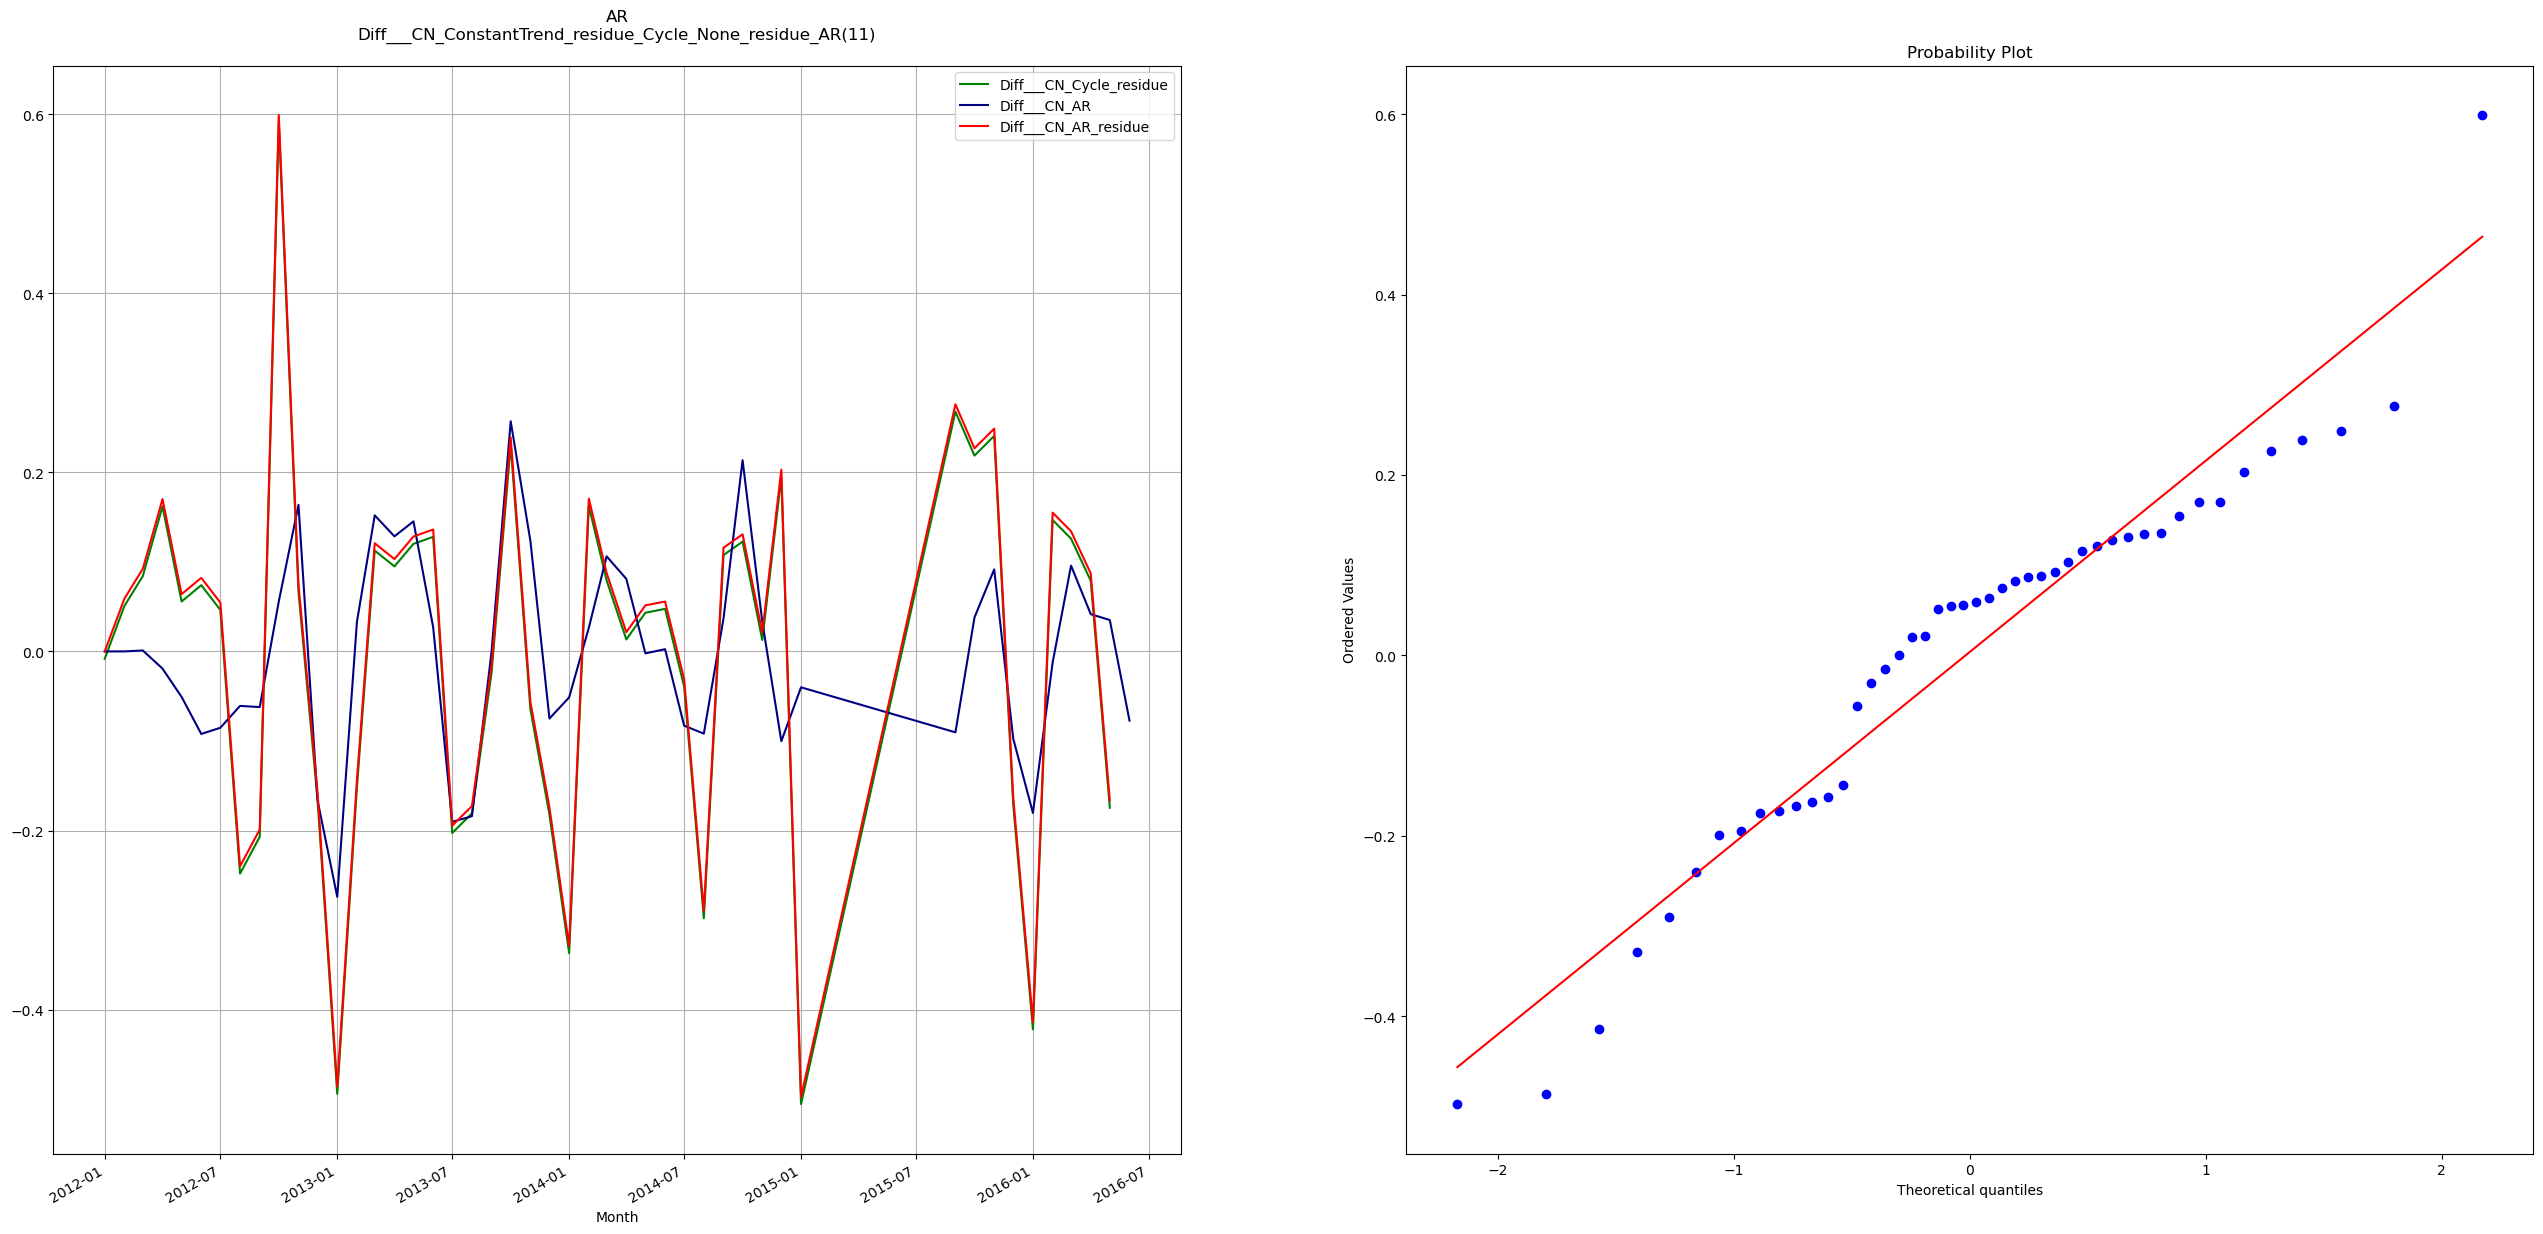

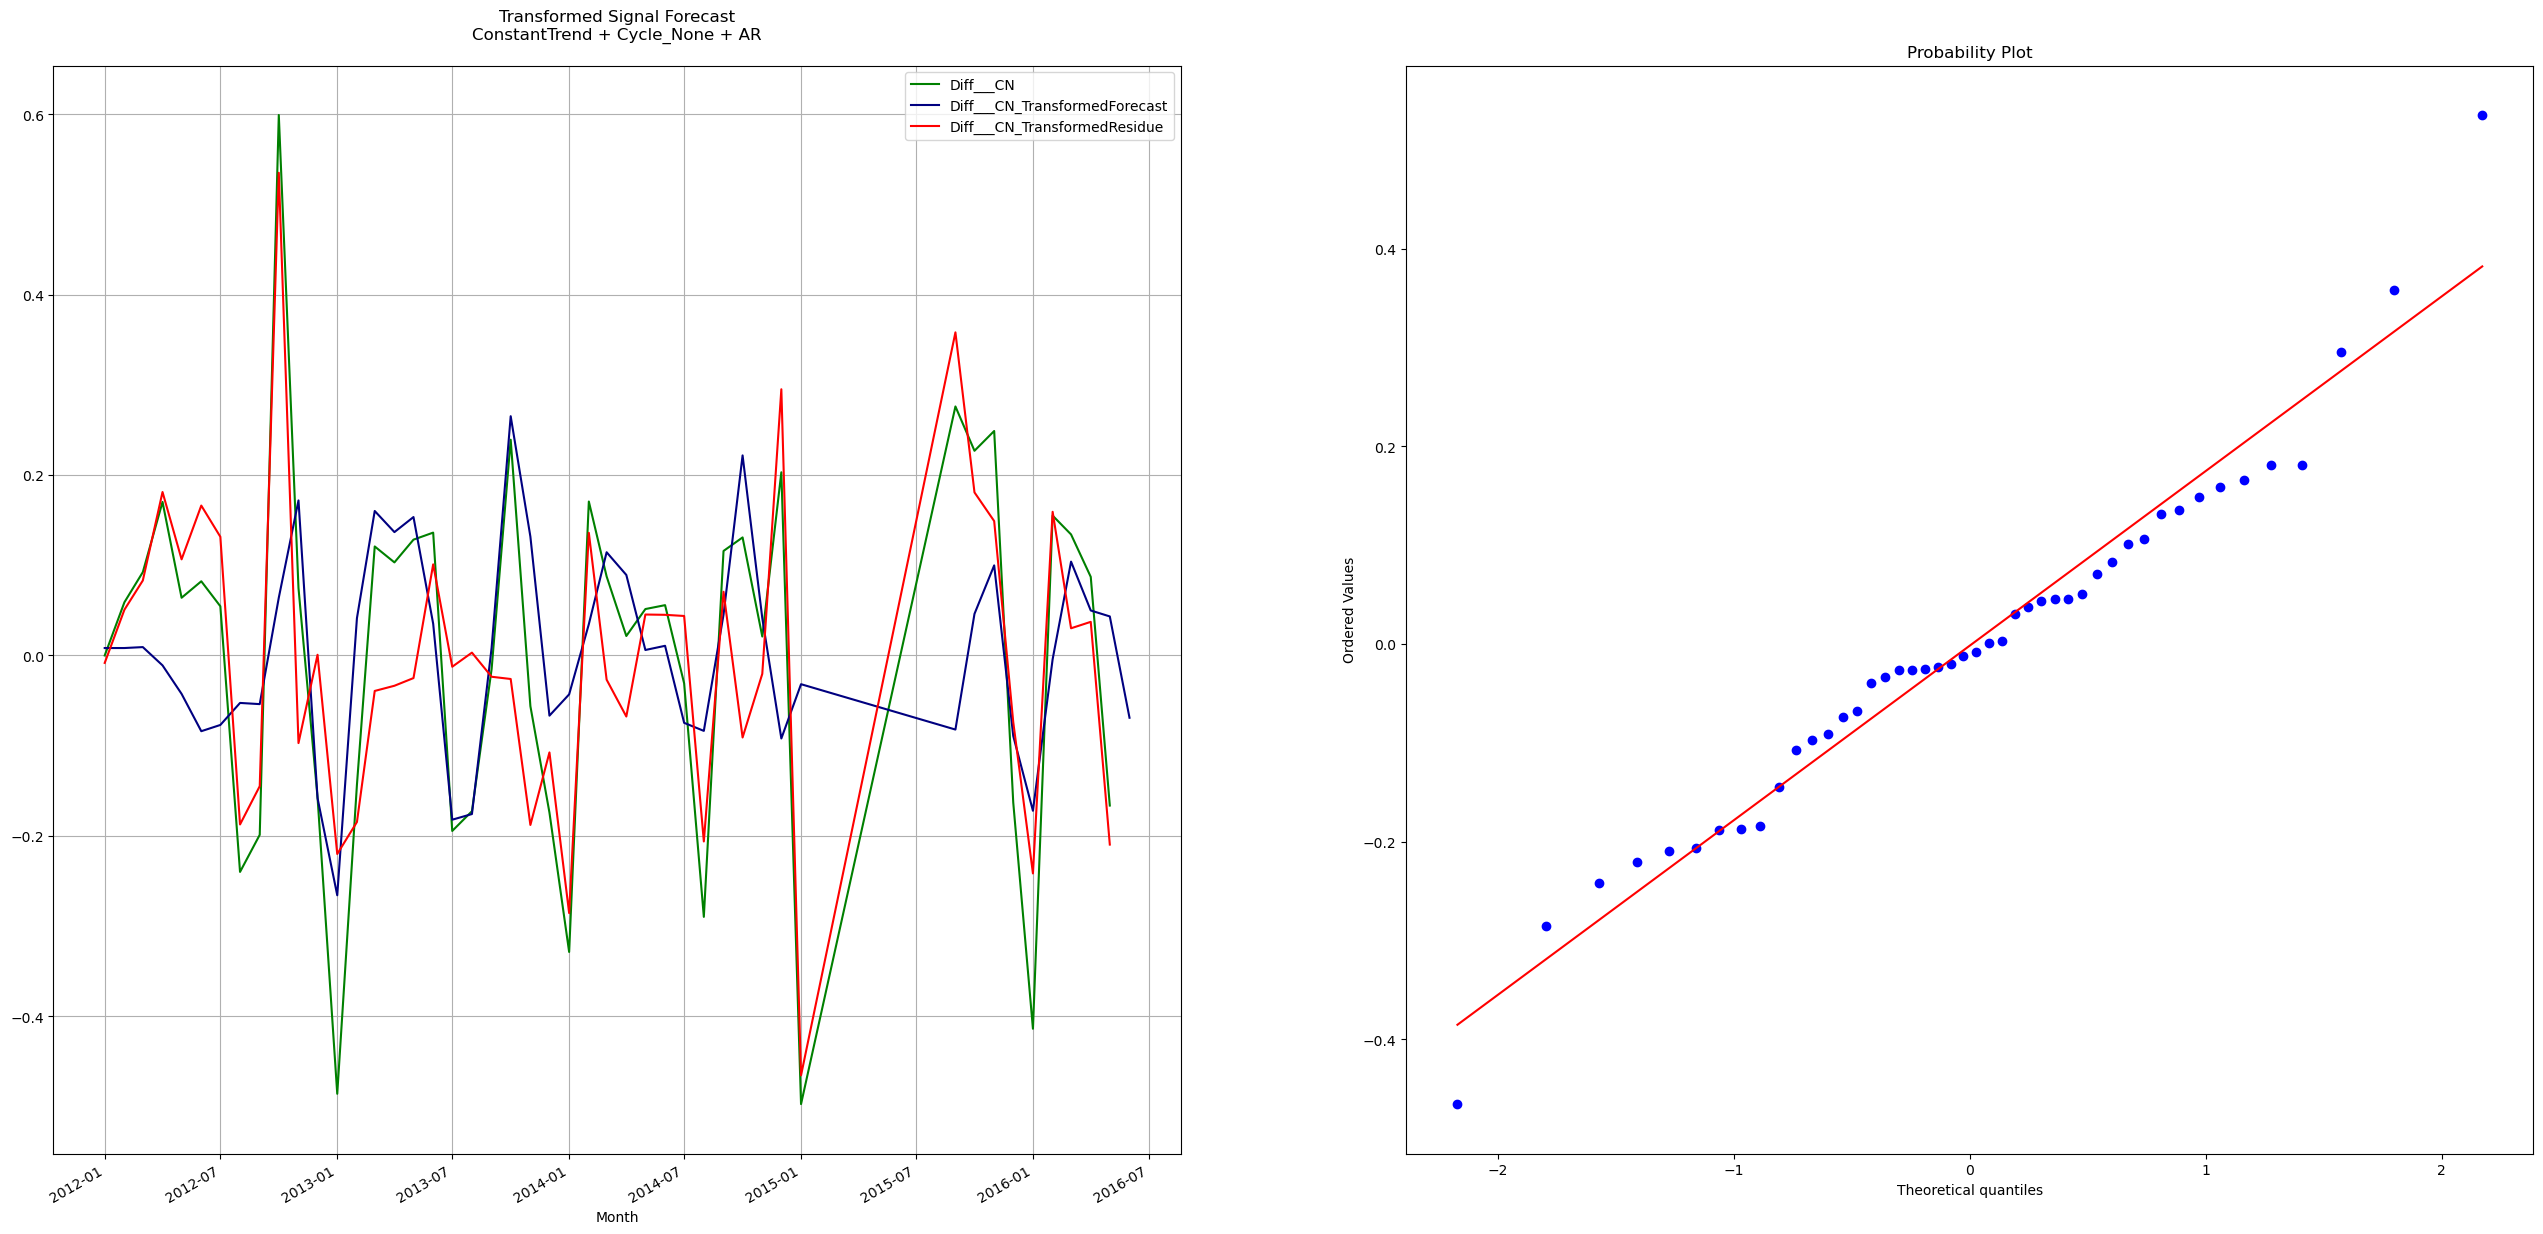

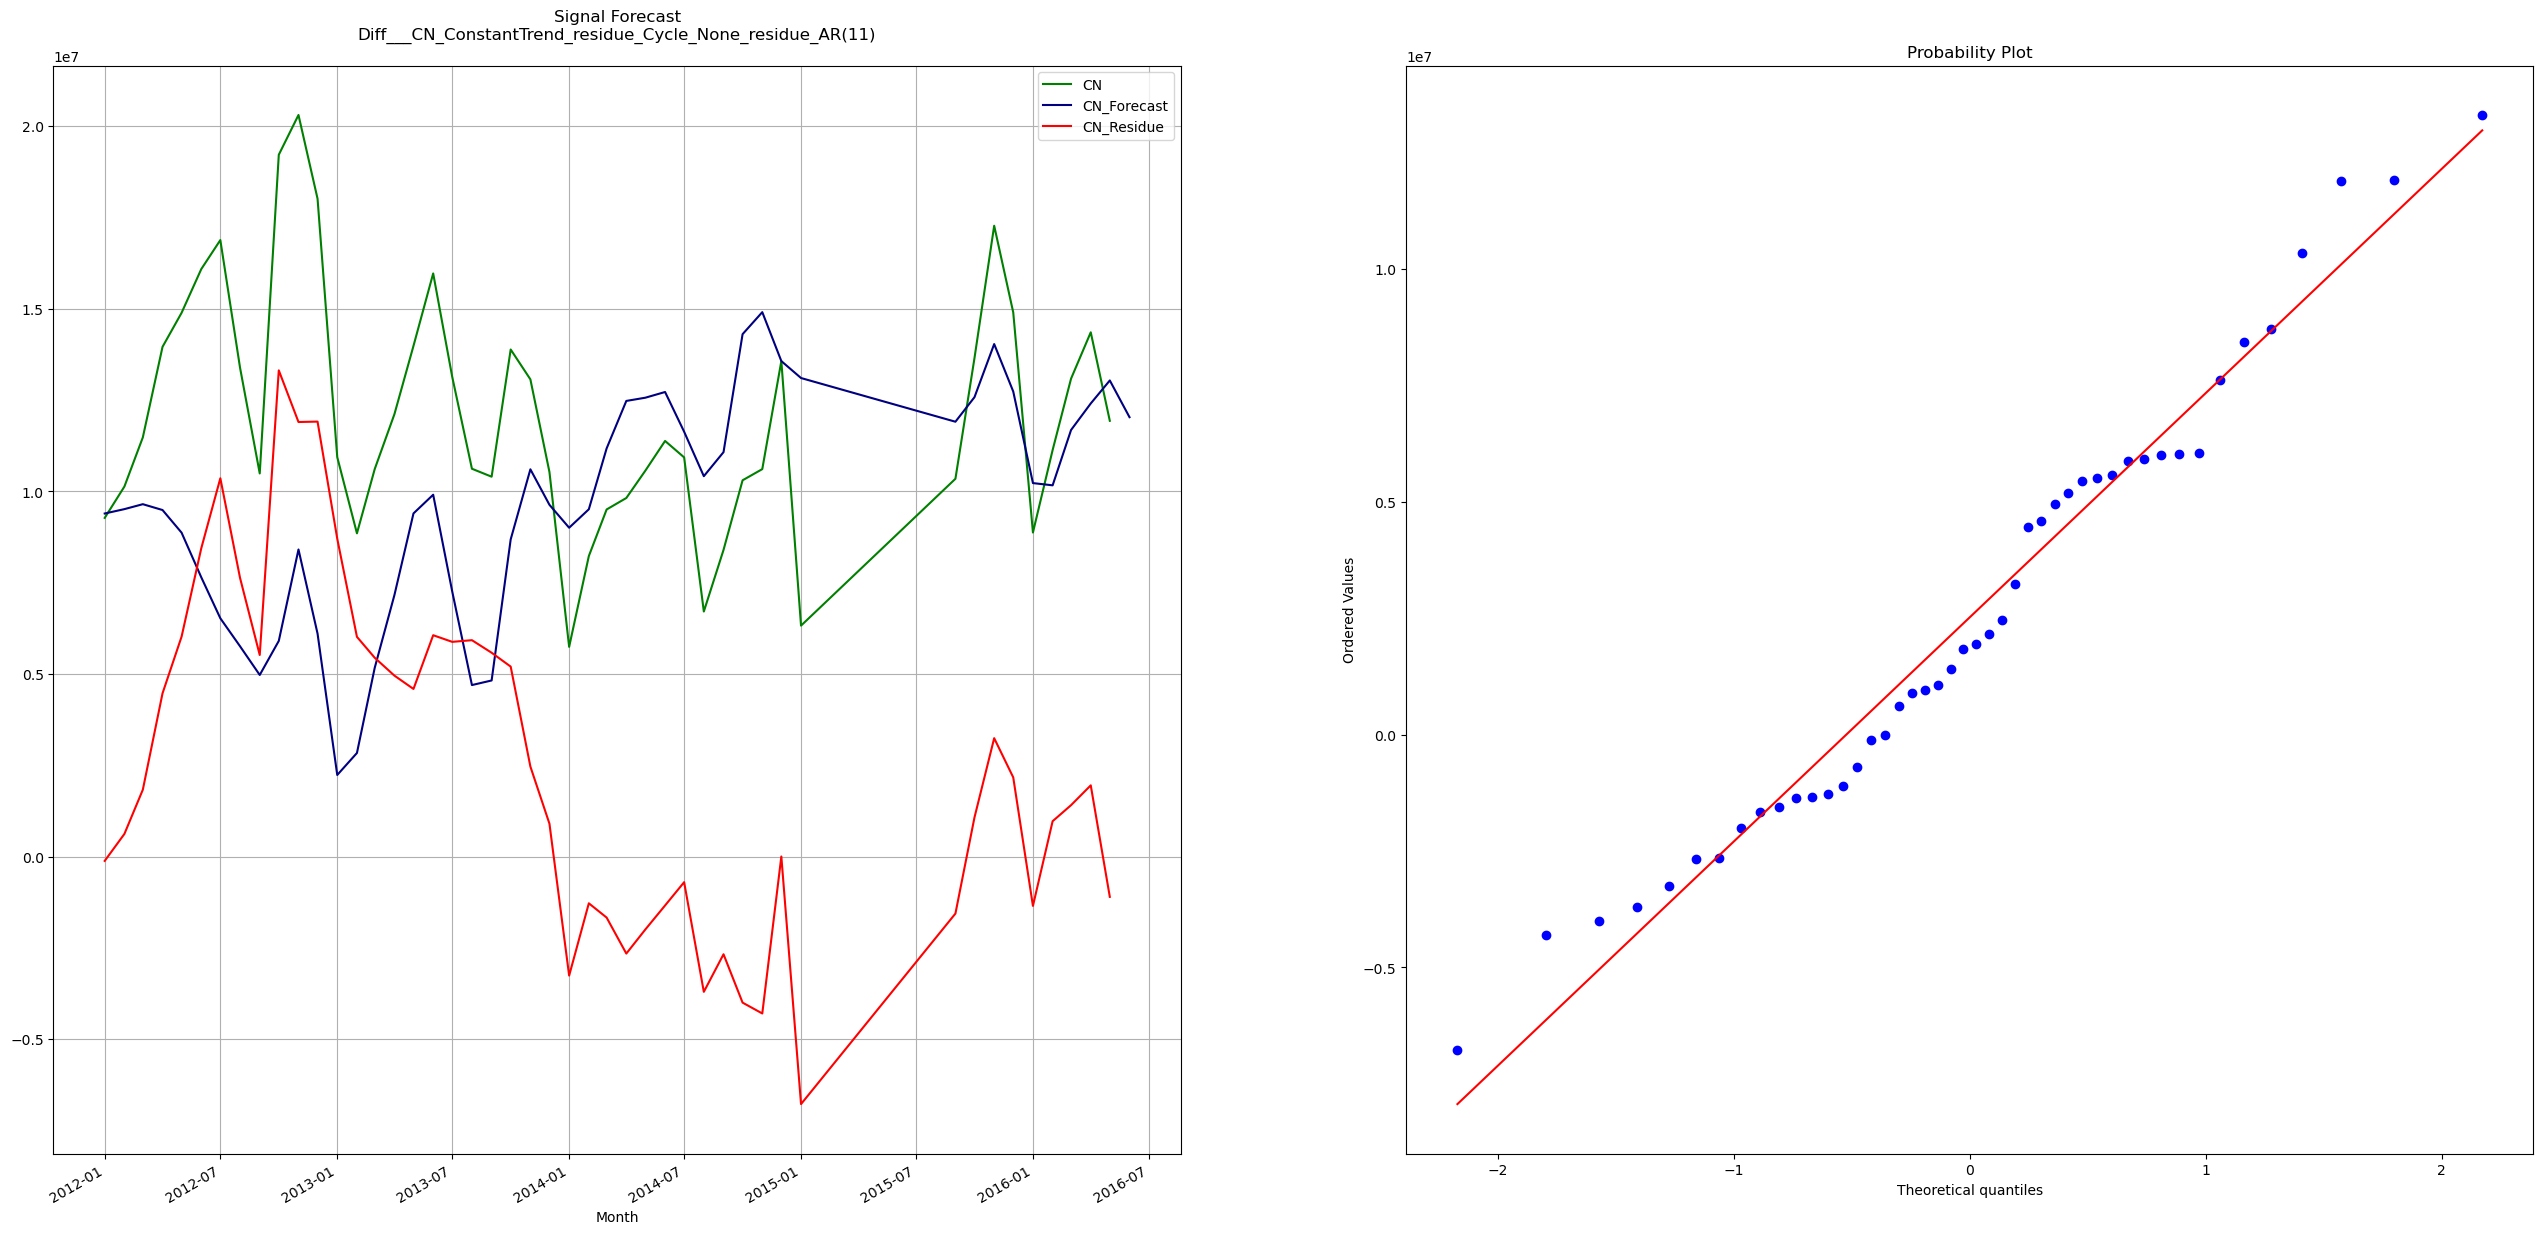

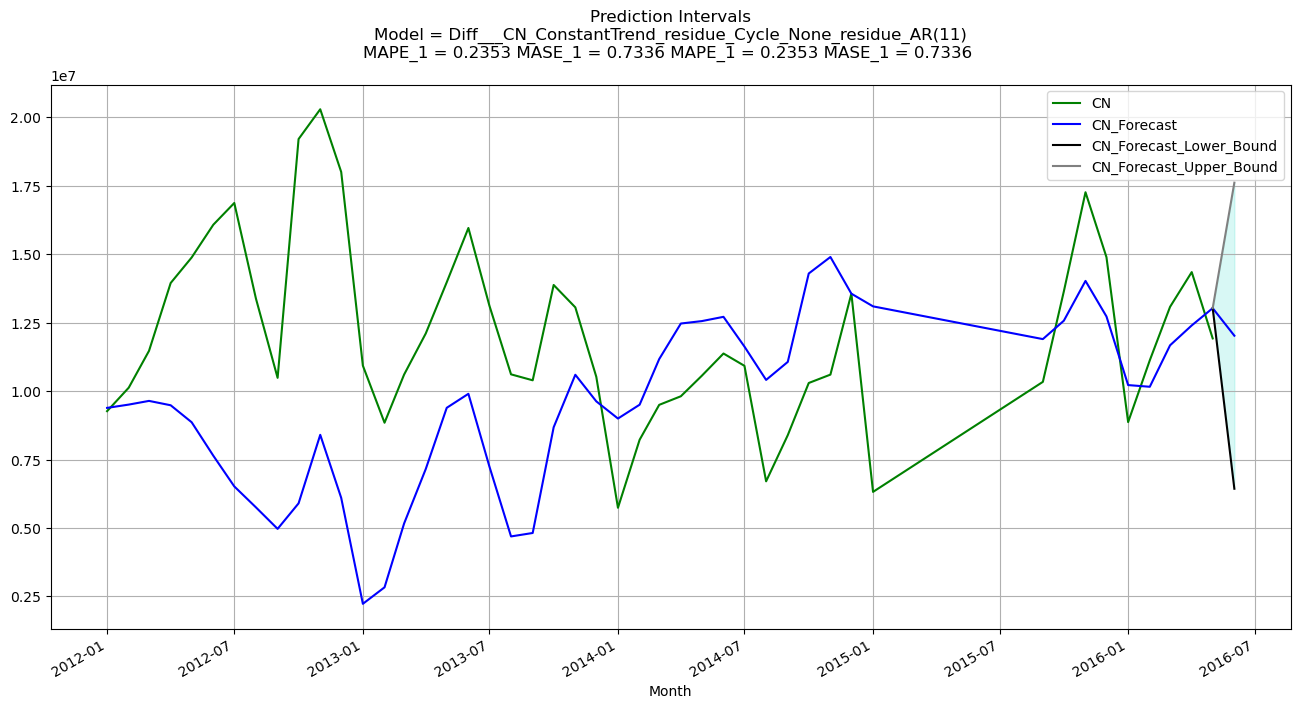

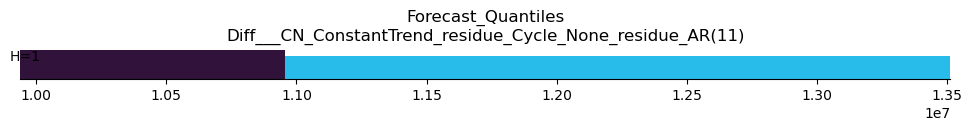

In [29]:
CN_Model.standardPlots()

## Hierarchical Forecast Combinations


### Bottom-Up / Top-Down and Middle-Out Forecasts

In [30]:
lEngine.mOptions.mHierarchicalCombinationMethod = ["BU" , 'TD' , 'MO' , 'OC'];
dfapp_out = lEngine.forecast(train_df, H);


INFO:pyaf.timing:('OPERATION_START', 'HIERARCHICAL_FORECAST')
INFO:pyaf.timing:('OPERATION_START', ('FORECASTING', {'Signals': ['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US', '_BLANC_BE', '_BLANC_CN', '_BLANC_DE', '_BLANC_GB', '_BLANC_US', '_ROUGE_BE', '_ROUGE_CN', '_ROUGE_DE', '_ROUGE_GB', '_ROUGE_US', '__BE', '__CN', '__DE', '__GB', '__US', '__'], 'Horizon': 4}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 3.029, ('FORECASTING', {'Signals': ['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUG

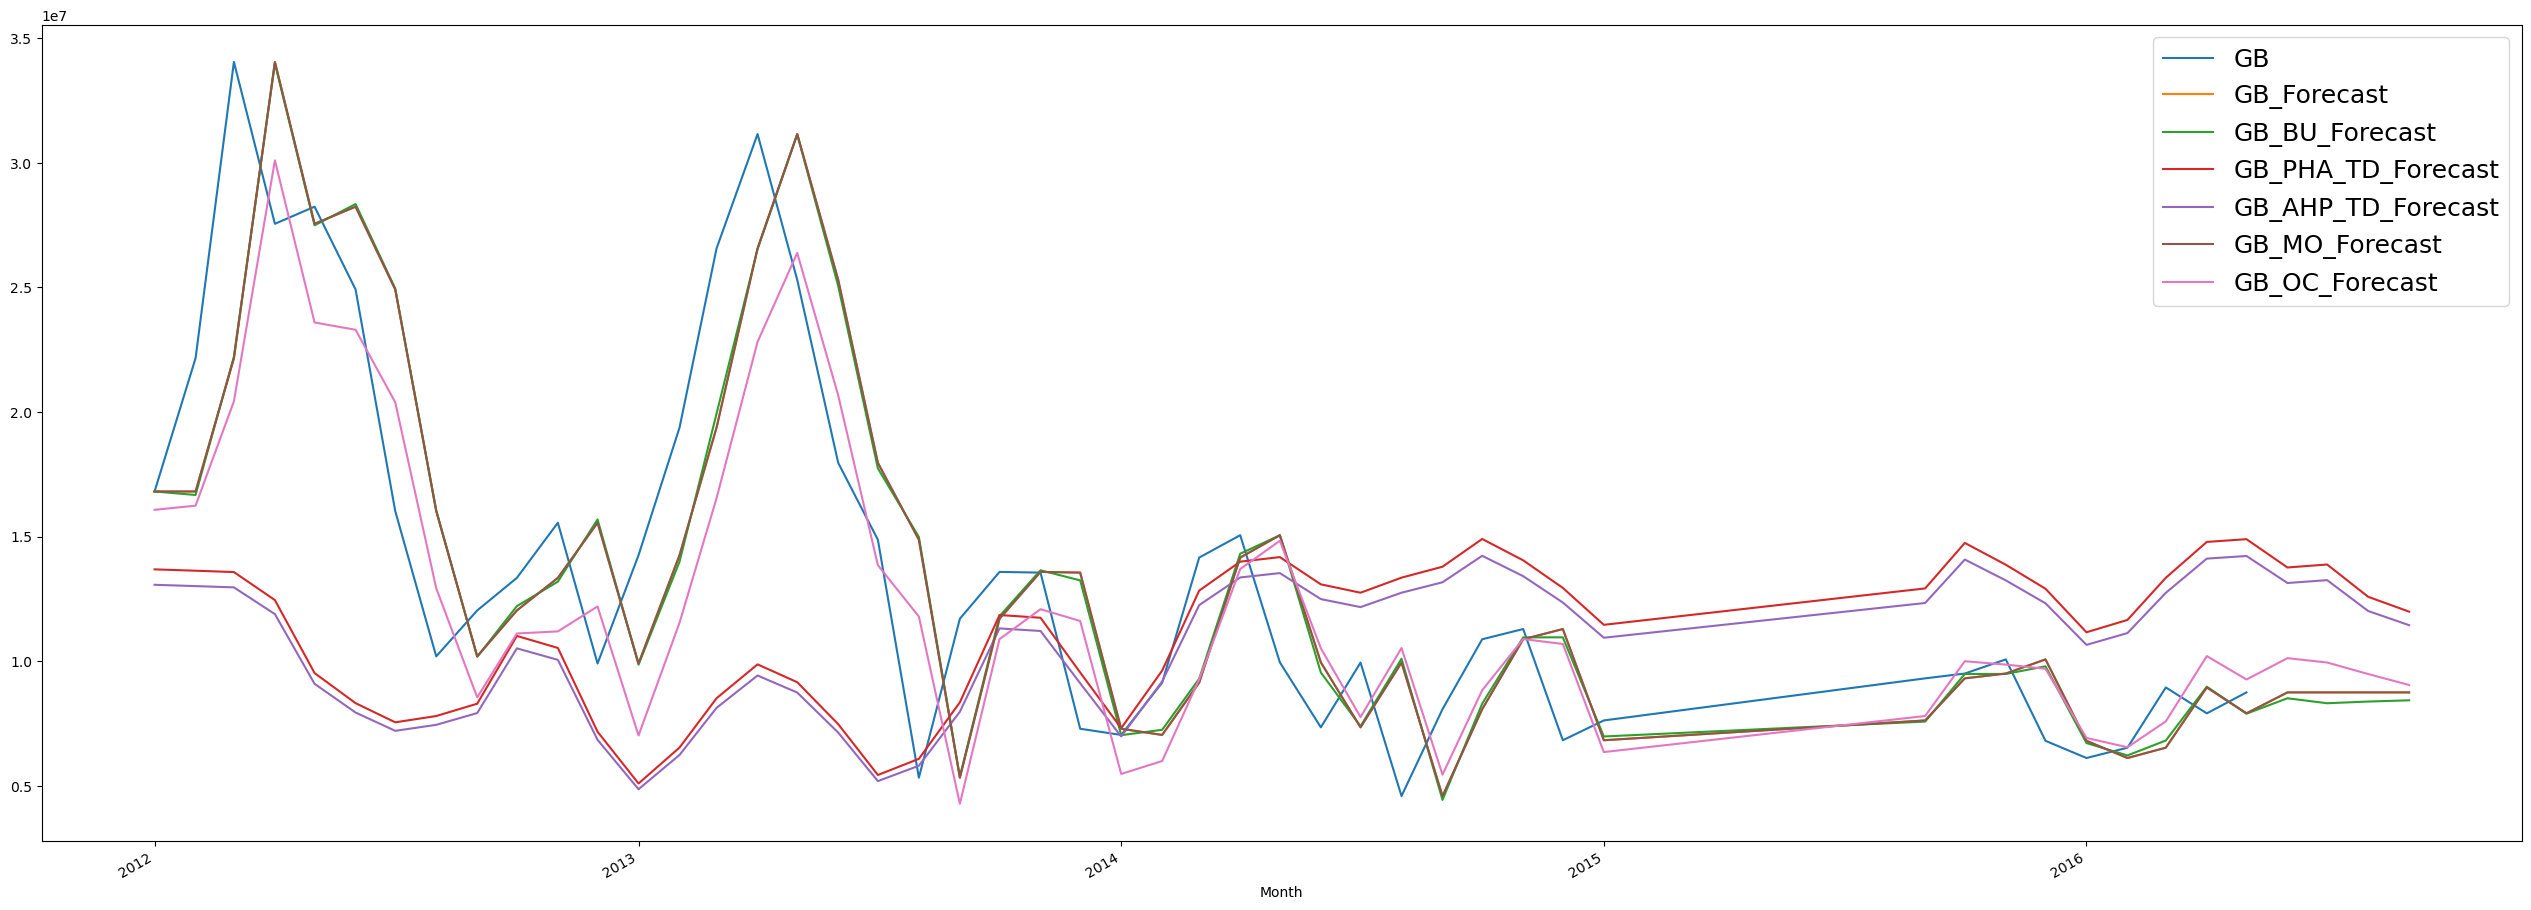

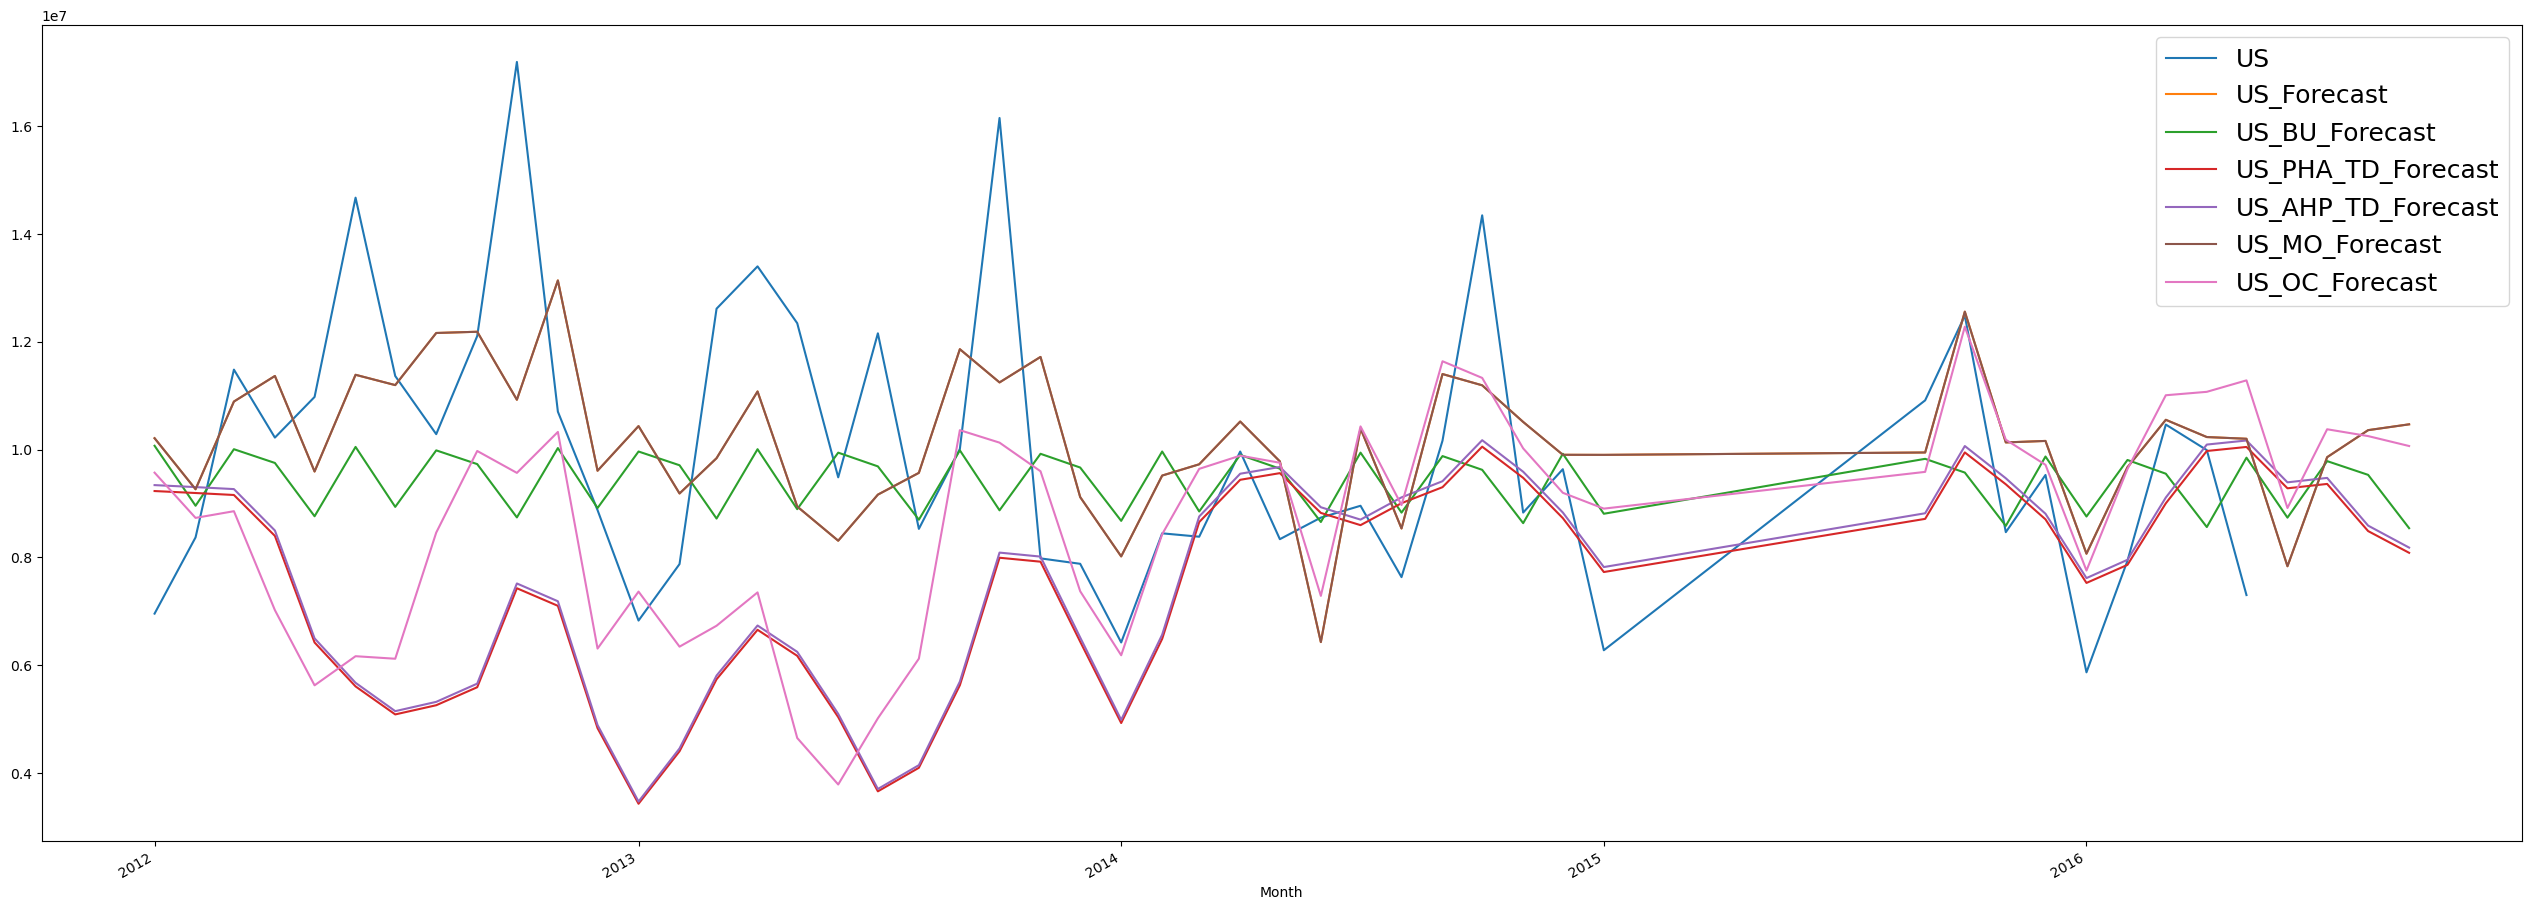

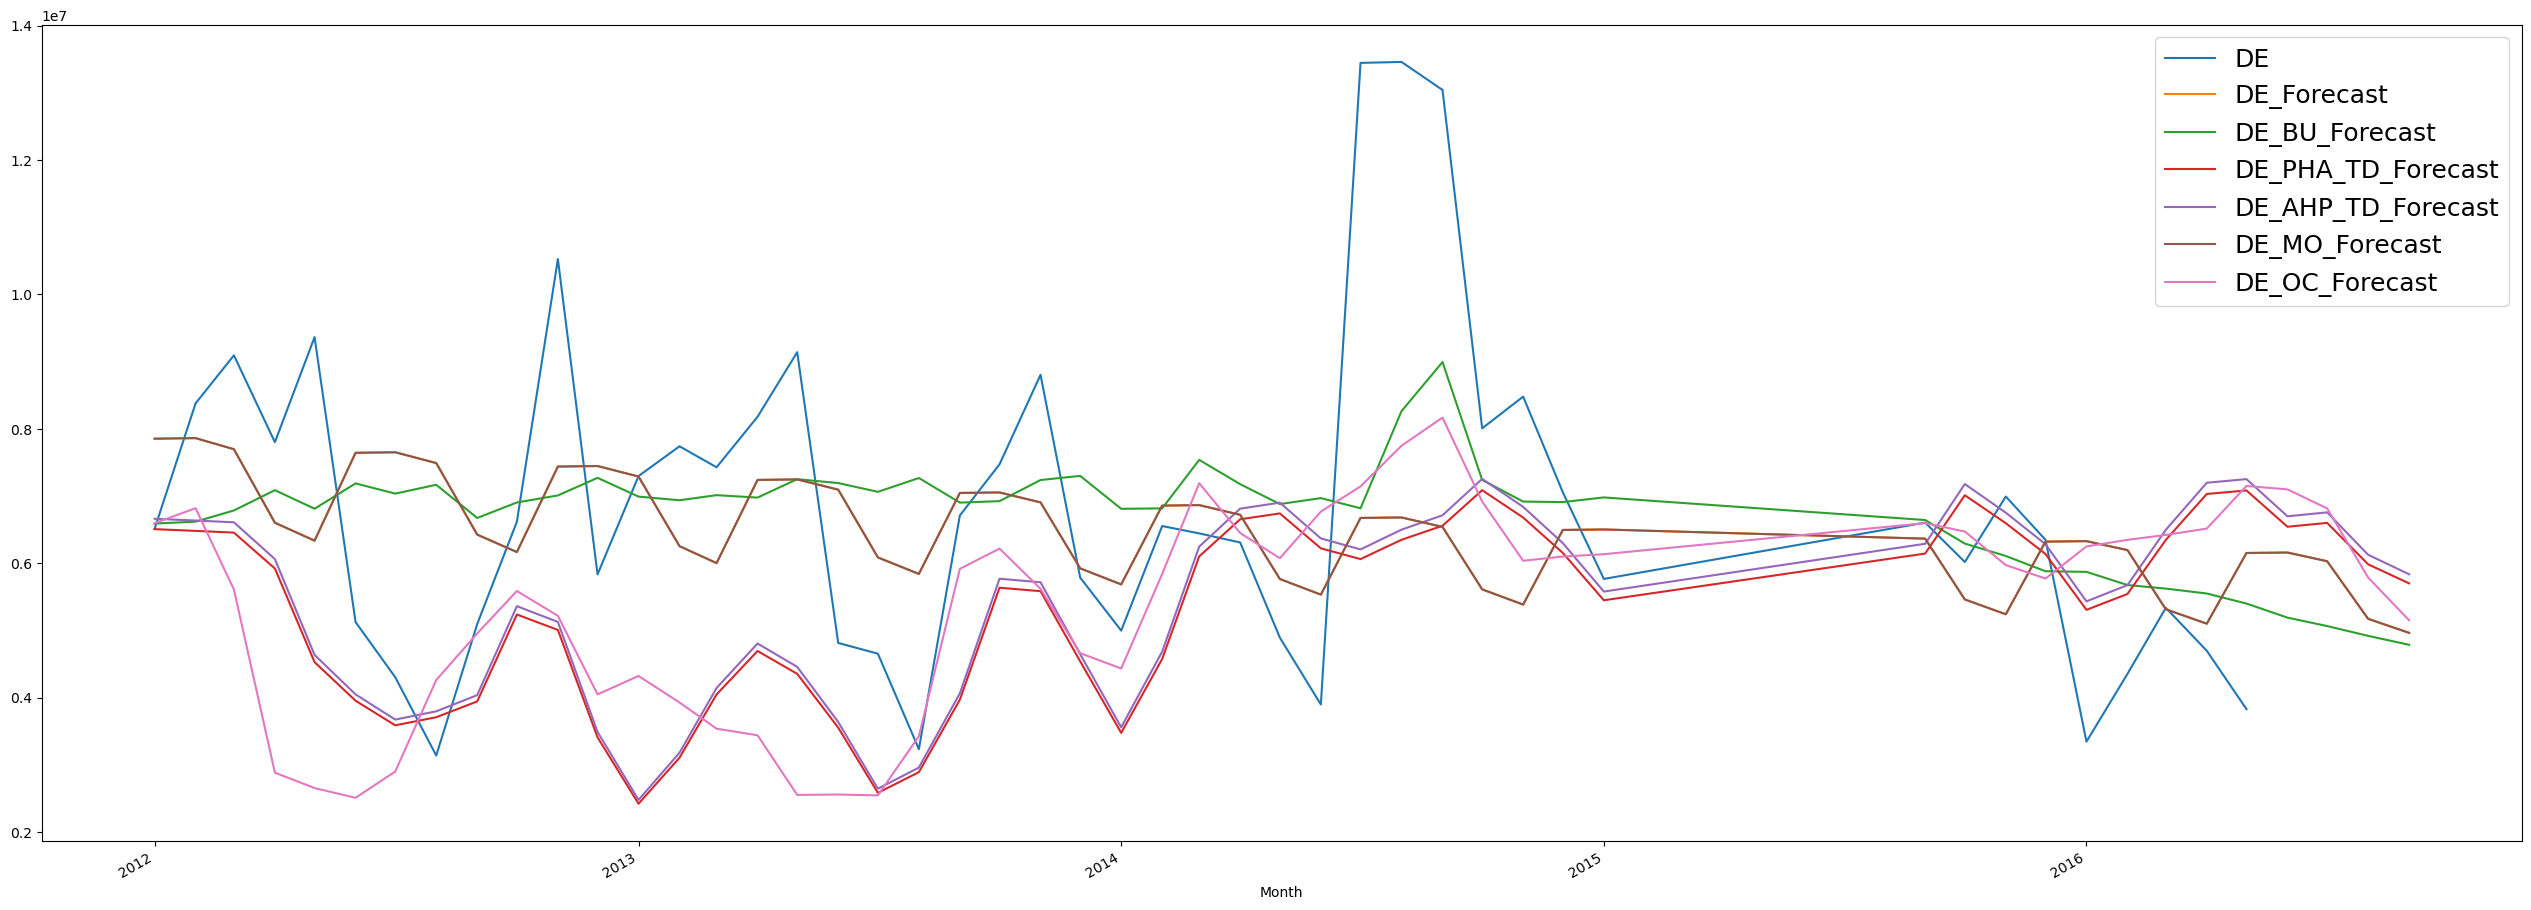

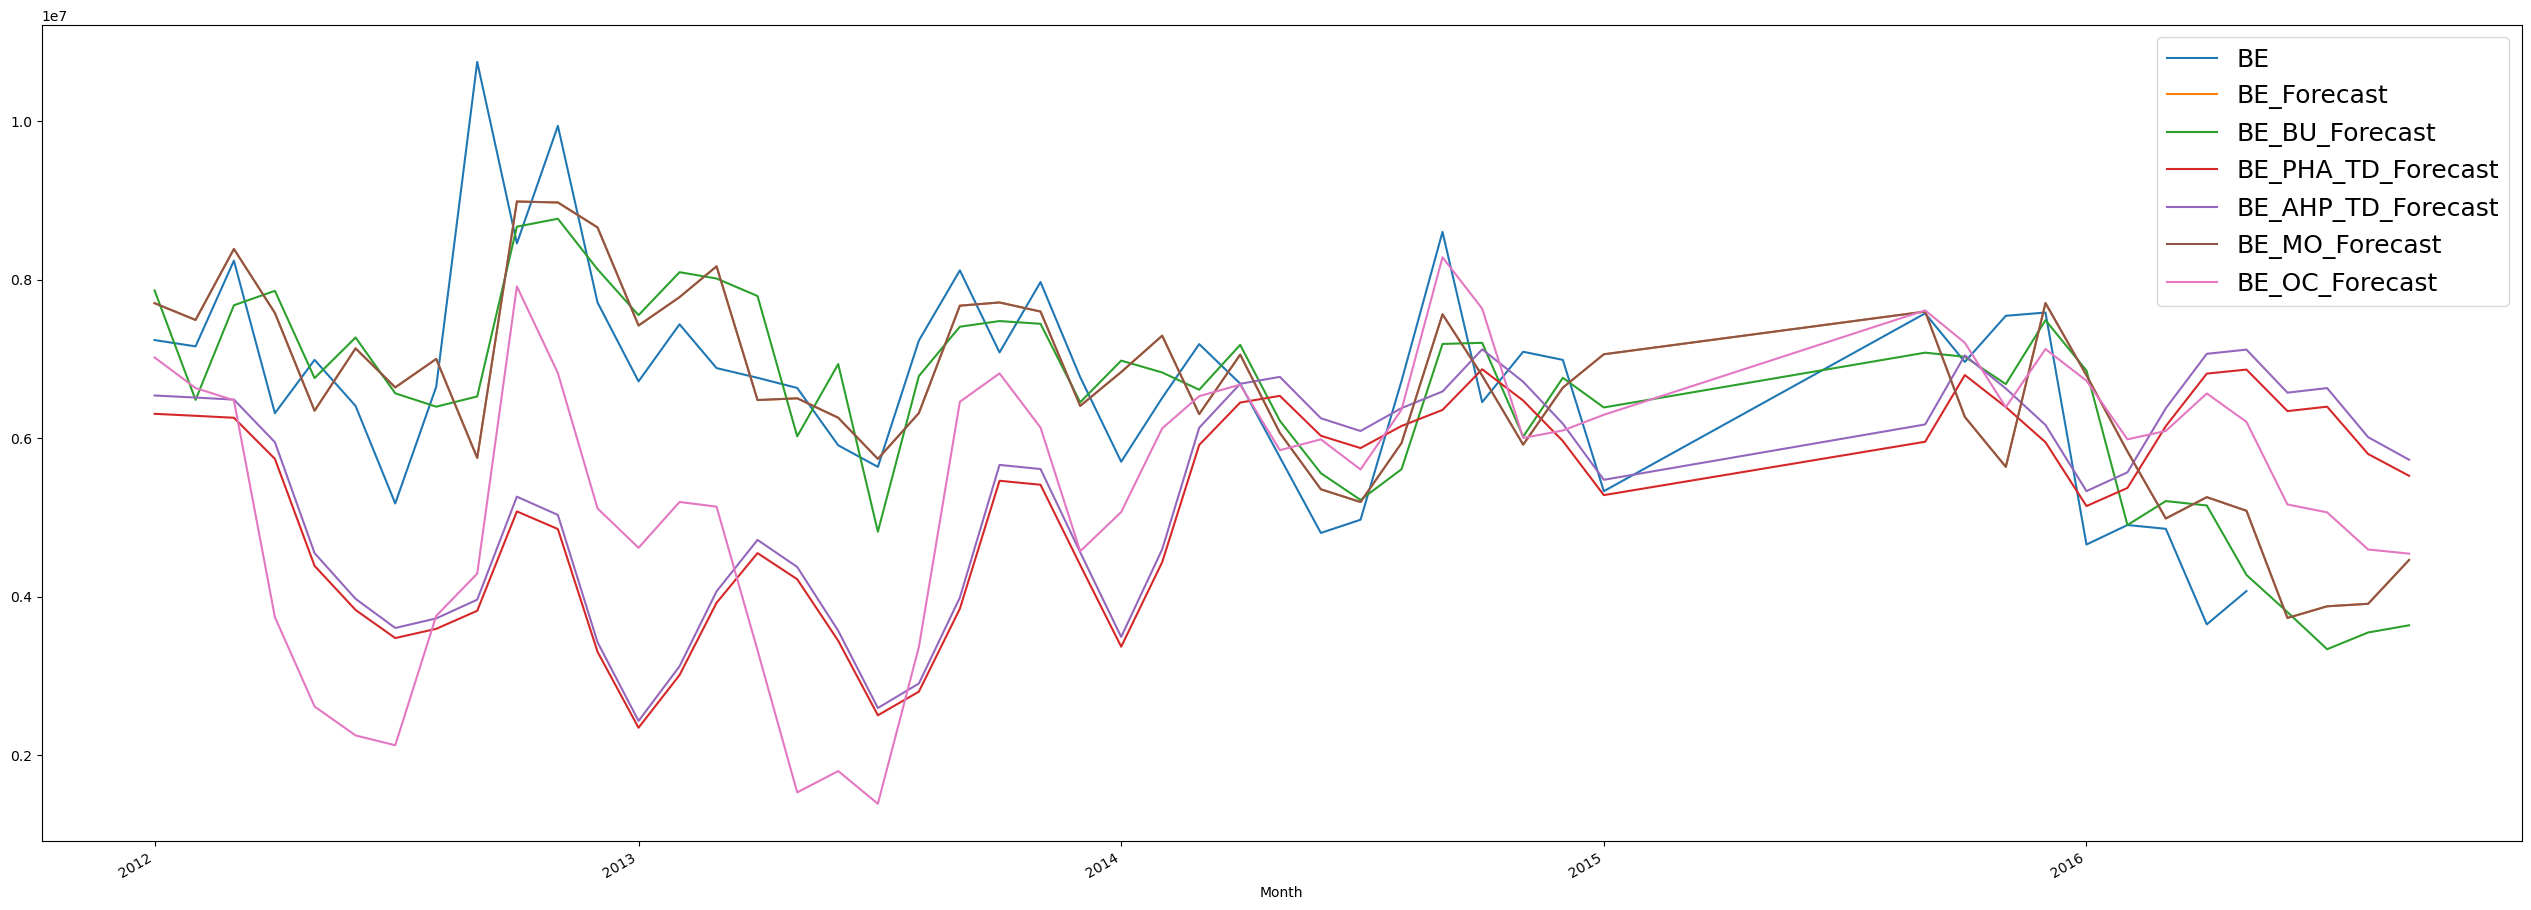

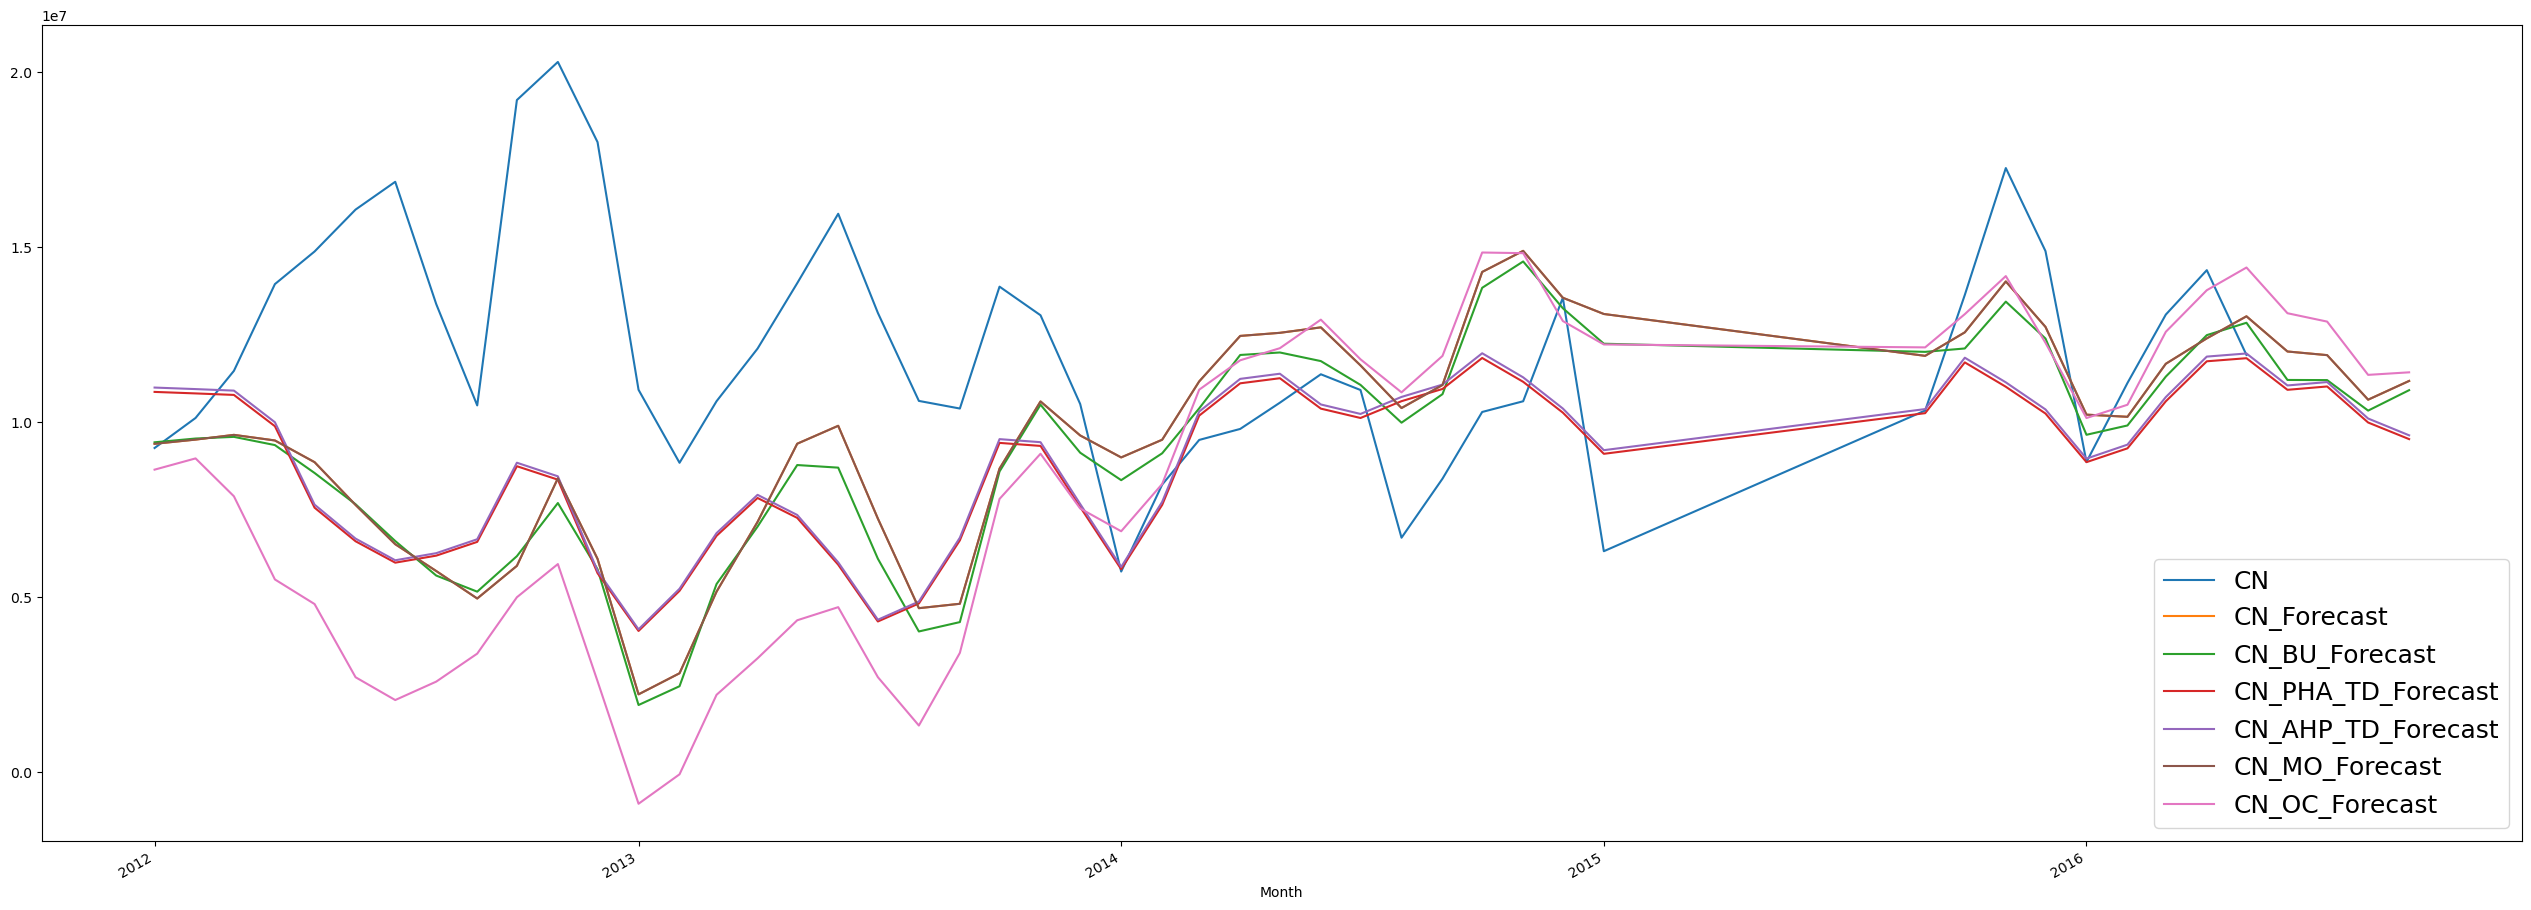

In [31]:
def strip_leading_underscores_if_needed(col_name):
    # this is a workaround for some matplotlib bugs. legend cannot contain names starting with '_'
    patched_name = col_name[2:] if(col_name.startswith('__')) else col_name
    patched_name = patched_name[1:] if(patched_name.startswith('_')) else patched_name
    return patched_name
    

dfapp_out.columns = [strip_leading_underscores_if_needed(col) for col in dfapp_out.columns]
for c in Countries:
    country = c
    dfapp_out.plot('Month' , 
                    [country , country + '_Forecast' , 
                     country + '_BU_Forecast',  
                     country + '_PHA_TD_Forecast',  
                     country + '_AHP_TD_Forecast'  ,  
                     country + '_MO_Forecast' ,
                     country + '_OC_Forecast'  ],
                figsize=(32 , 12)).legend(fontsize=18)

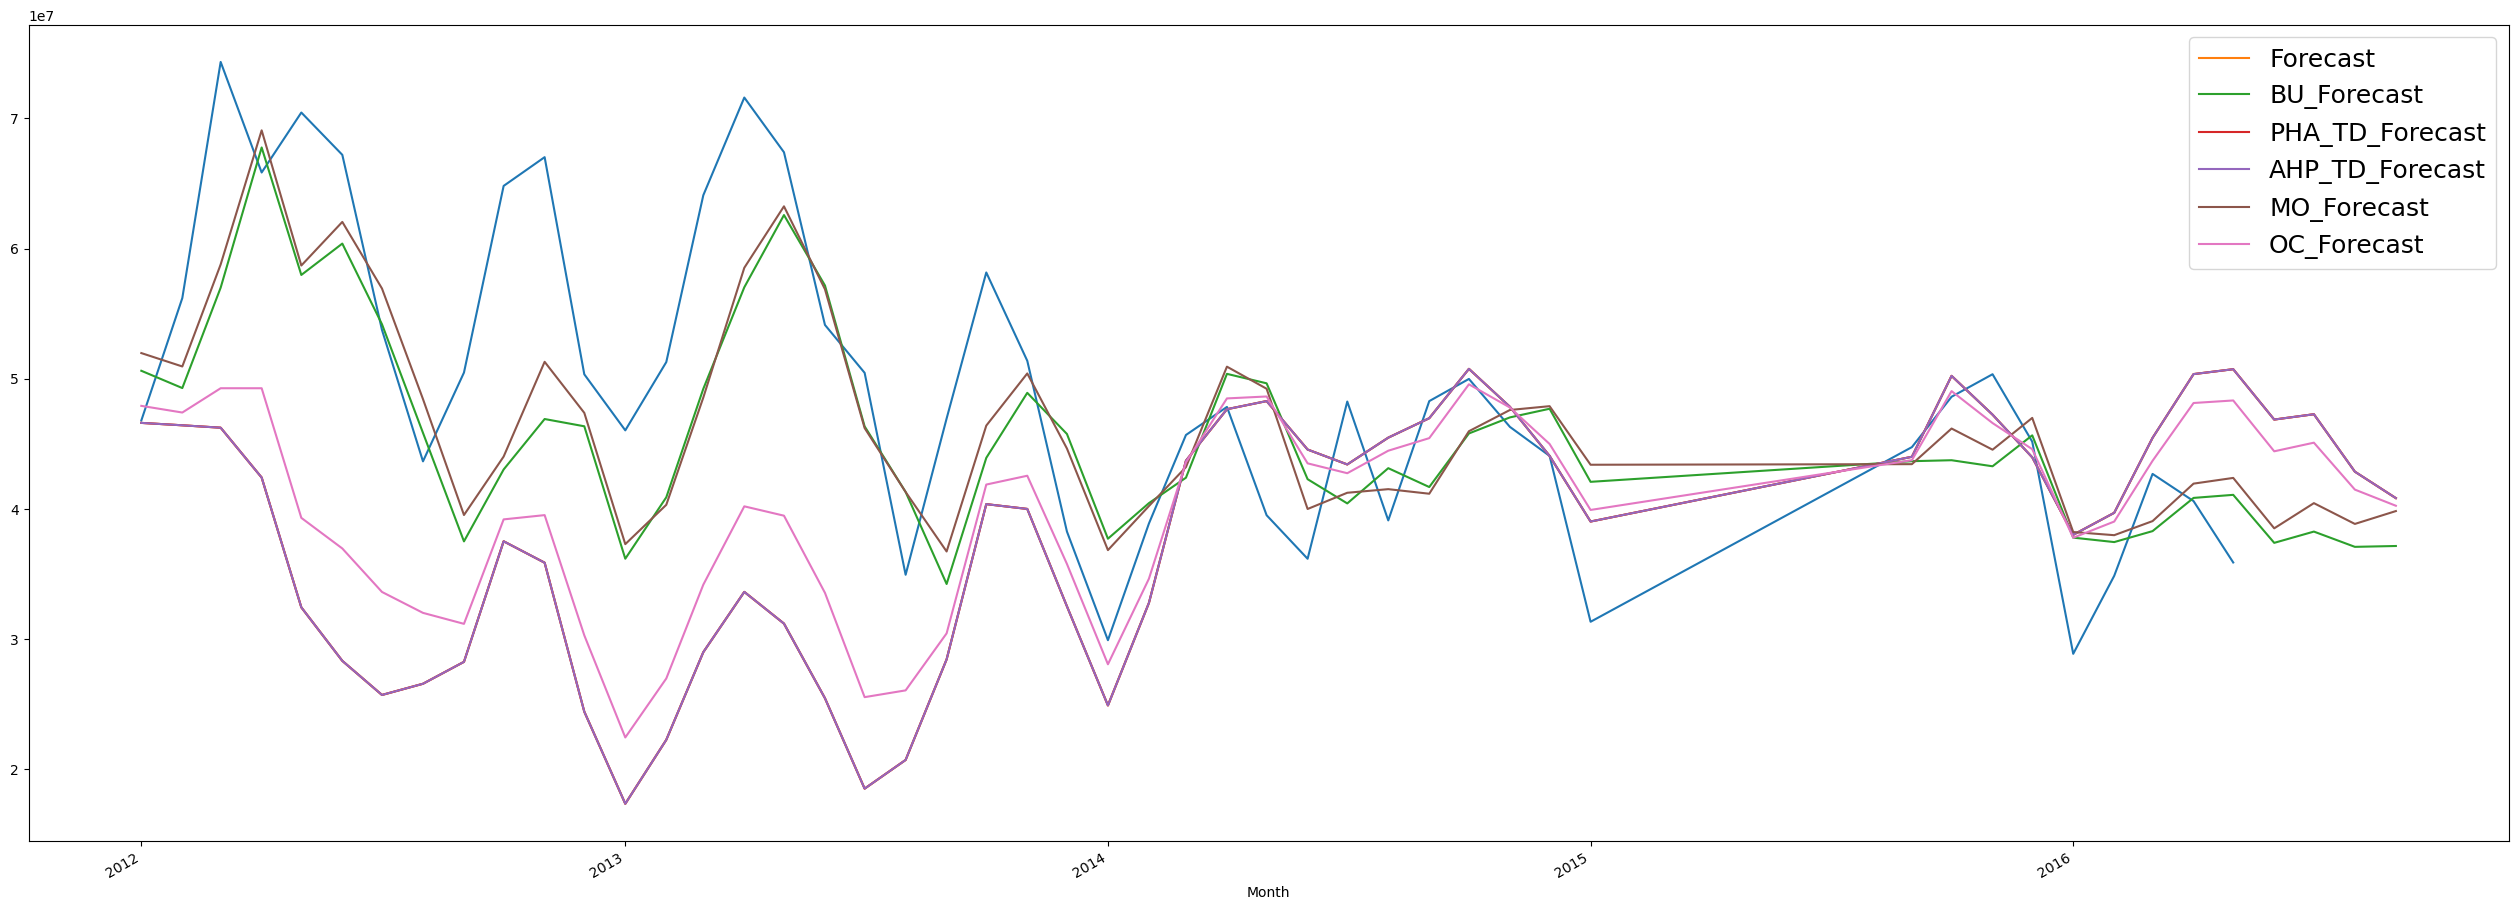

In [32]:
world = ''
dfapp_out.plot('Month' , 
                [world , world + 'Forecast' , 
                 world + 'BU_Forecast',  
                 world + 'PHA_TD_Forecast',  
                 world + 'AHP_TD_Forecast'  ,  
                 world + 'MO_Forecast' ,
                 world + 'OC_Forecast'  ],
                figsize=(32 , 12)).legend(fontsize=18)

In [33]:
dfapp_out.columns

Index(['Month', 'ALSACE_BLANC_BE', 'ALSACE_BLANC_BE_Forecast',
       'ALSACE_BLANC_BE_Forecast_Lower_Bound',
       'ALSACE_BLANC_BE_Forecast_Upper_Bound', 'ALSACE_BLANC_CN',
       'ALSACE_BLANC_CN_Forecast', 'ALSACE_BLANC_CN_Forecast_Lower_Bound',
       'ALSACE_BLANC_CN_Forecast_Upper_Bound', 'ALSACE_BLANC_DE',
       ...
       'ROUGE_CN_OC_Forecast', 'ROUGE_DE_OC_Forecast', 'ROUGE_GB_OC_Forecast',
       'ROUGE_US_OC_Forecast', 'BE_OC_Forecast', 'CN_OC_Forecast',
       'DE_OC_Forecast', 'GB_OC_Forecast', 'US_OC_Forecast', 'OC_Forecast'],
      dtype='object', length=325)